# Energies and logits

Results referenced in 25b_Section_2_research.ipynb.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
fp = "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_2/3VRL_high__vs__3VRL_looser/attributions/v2.0-2/attribution_records.json"
fp_test_1 = "../data/MiniAbsolut_Splits/MiniAbsolut_Seed2/3VRL/high_test_5000.tsv"
fp_test_2 = "../data/MiniAbsolut_Splits/MiniAbsolut_Seed2/3VRL/looserX_test_5000.tsv"

df_test_1 = pd.read_csv(fp_test_1, sep="\t")
df_test_1["class"] = "positive"
df_test_2 = pd.read_csv(fp_test_2, sep="\t")
df_test_2["class"] = "negative"
df_test = pd.concat([df_test_1, df_test_2], axis=0)

with open(fp, "r") as f:
    data = json.load(f)

In [3]:
df_test

Unnamed: 0 ID_slide_Variant                 CDR3   Best        Slide  \
0          21441      3232108_00a          CASWIWYFDVW   True  CASWIWYFDVW   
1           1746      5717631_00a       CARGQLLLRAFDYW   True  CARGQLLLRAF   
2          23533      7042338_00a    CARVGALLCFYYAMDYW  False  CARVGALLCFY   
3          24546      2643075_00a     CARPYLFMDLWYFDVW   True  CARPYLFMDLW   
4          24013      2530684_00a     CARNHLLLRFYYFDYW   True  CARNHLLLRFY   
...          ...              ...                  ...    ...          ...   
4995       50115      5675855_00a   CARWTLFTTVVAWDFDVW   True  CARWTLFTTVV   
4996        6412      4705744_04a      CARGIYYGIWYFDVW   True  IYYGIWYFDVW   
4997      150264      4154112_03a       CARYPLLLRGFDYW  False  YPLLLRGFDYW   
4998      146323       747612_01a      CARILWLEDWYFDVW   True  ARILWLEDWYF   
4999      162989      3986551_01a  CARWTFPLLLPYYYAMDYW  False  ARWTFPLLLPY   

      Energy          Structure    Source Antigen     class  
0     -97.84  137570-BSDLRDDSLU  mascotte    3VRL  positive  
1     -98.82  137570-BSDLRDDSLU  mascotte    3VRL  positive  
2     -98.92  137570-BSDLRDDSLU  mascotte    3VRL  positive  
3     -98.25  137570-BSDLRDDSLU  mascotte    3VRL  positive  
4     -97.92  137570-BSDLRDDSLU  mascotte    3VRL  positive  
...      ...                ...       ...     ...       ...  
4995  -94.60  137570-BSDLRDDSLU   looserX    3VRL  negative  
4996  -95.83  137570-BSDLRDDSLU   looserX    3VRL  negative  
4997  -94.88  137442-BRDSLLUDLS   looserX    3VRL  negative  
4998  -93.43  137570-BLDSRRSURS   looserX    3VRL  negative  
4999  -95.95  137248-LSSRLDSLLU   looserX    3VRL  negative  

[10000 rows x 10 columns]

In [4]:
df = pd.DataFrame.from_records(data)
df = pd.merge(df, df_test, left_on="slide", right_on="Slide")
df.head()

slide     logits  expits  y_pred  y_true  is_pred_correct  \
0  CARWGFLFWYF  36.035297     1.0       1       1             True   
1  CARVHLLLLYF  35.692356     1.0       1       1             True   
2  CARWGWLLQIL  35.528095     1.0       1       1             True   
3  CARVGWLLPIL  34.038166     1.0       1       1             True   
4  CARWGLLLYYF  33.931423     1.0       1       1             True   

                               DeepLIFT_LOCAL_v2.0-2  \
0  [[0.6532908082008362, 2.525751829147339, 0.0, ...   
1  [[0.5929000377655029, 3.0686094760894775, 0.0,...   
2  [[0.7790840864181519, 2.0747859477996826, 0.0,...   
3  [[0.0, 2.375030040740967, 0.0, 0.0, 0.0, 0.515...   
4  [[0.710521399974823, 2.989356279373169, 0.0, 0...   

                          DeepLIFT_GLOBAL_R10_v2.0-2     exec_time  \
0  [[-3.4908359050750732, 2.852792263031006, -10....  18184.208947   
1  [[-2.609302282333374, 3.1613006591796875, -9.6...  18184.208947   
2  [[-4.884578704833984, 2.9810032844543457, -12....  18184.208947   
3  [[-4.852635383605957, 2.7822837829589844, -11....  18184.208947   
4  [[-3.28698992729187, 2.9863240718841553, -10.5...  18184.208947   

   Unnamed: 0 ID_slide_Variant             CDR3  Best        Slide  Energy  \
0        1564      6262006_00a   CARWGFLFWYFDVW  True  CARWGFLFWYF -106.40   
1        2123      3919327_00a   CARVHLLLLYFDYW  True  CARVHLLLLYF -107.71   
2       28874      5157580_00a   CARWGWLLQILTYW  True  CARWGWLLQIL -105.16   
3       17517      1349039_00a  CARVGWLLPILFDYW  True  CARVGWLLPIL -105.31   
4        3854       564228_00a   CARWGLLLYYFDYW  True  CARWGLLLYYF -105.77   

           Structure    Source Antigen     class  
0  137570-BSDLRDDSLU  mascotte    3VRL  positive  
1  137570-BSDLRDDSLU  mascotte    3VRL  positive  
2  137570-BSDLRDDSLU  mascotte    3VRL  positive  
3  137570-BSDLRDDSLU  mascotte    3VRL  positive  
4  137570-BSDLRDDSLU  mascotte    3VRL  positive

/tmp/ipykernel_834887/2559338079.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


Text(-109, -10, 'r = -0.94\n$r^2$ = 0.88')

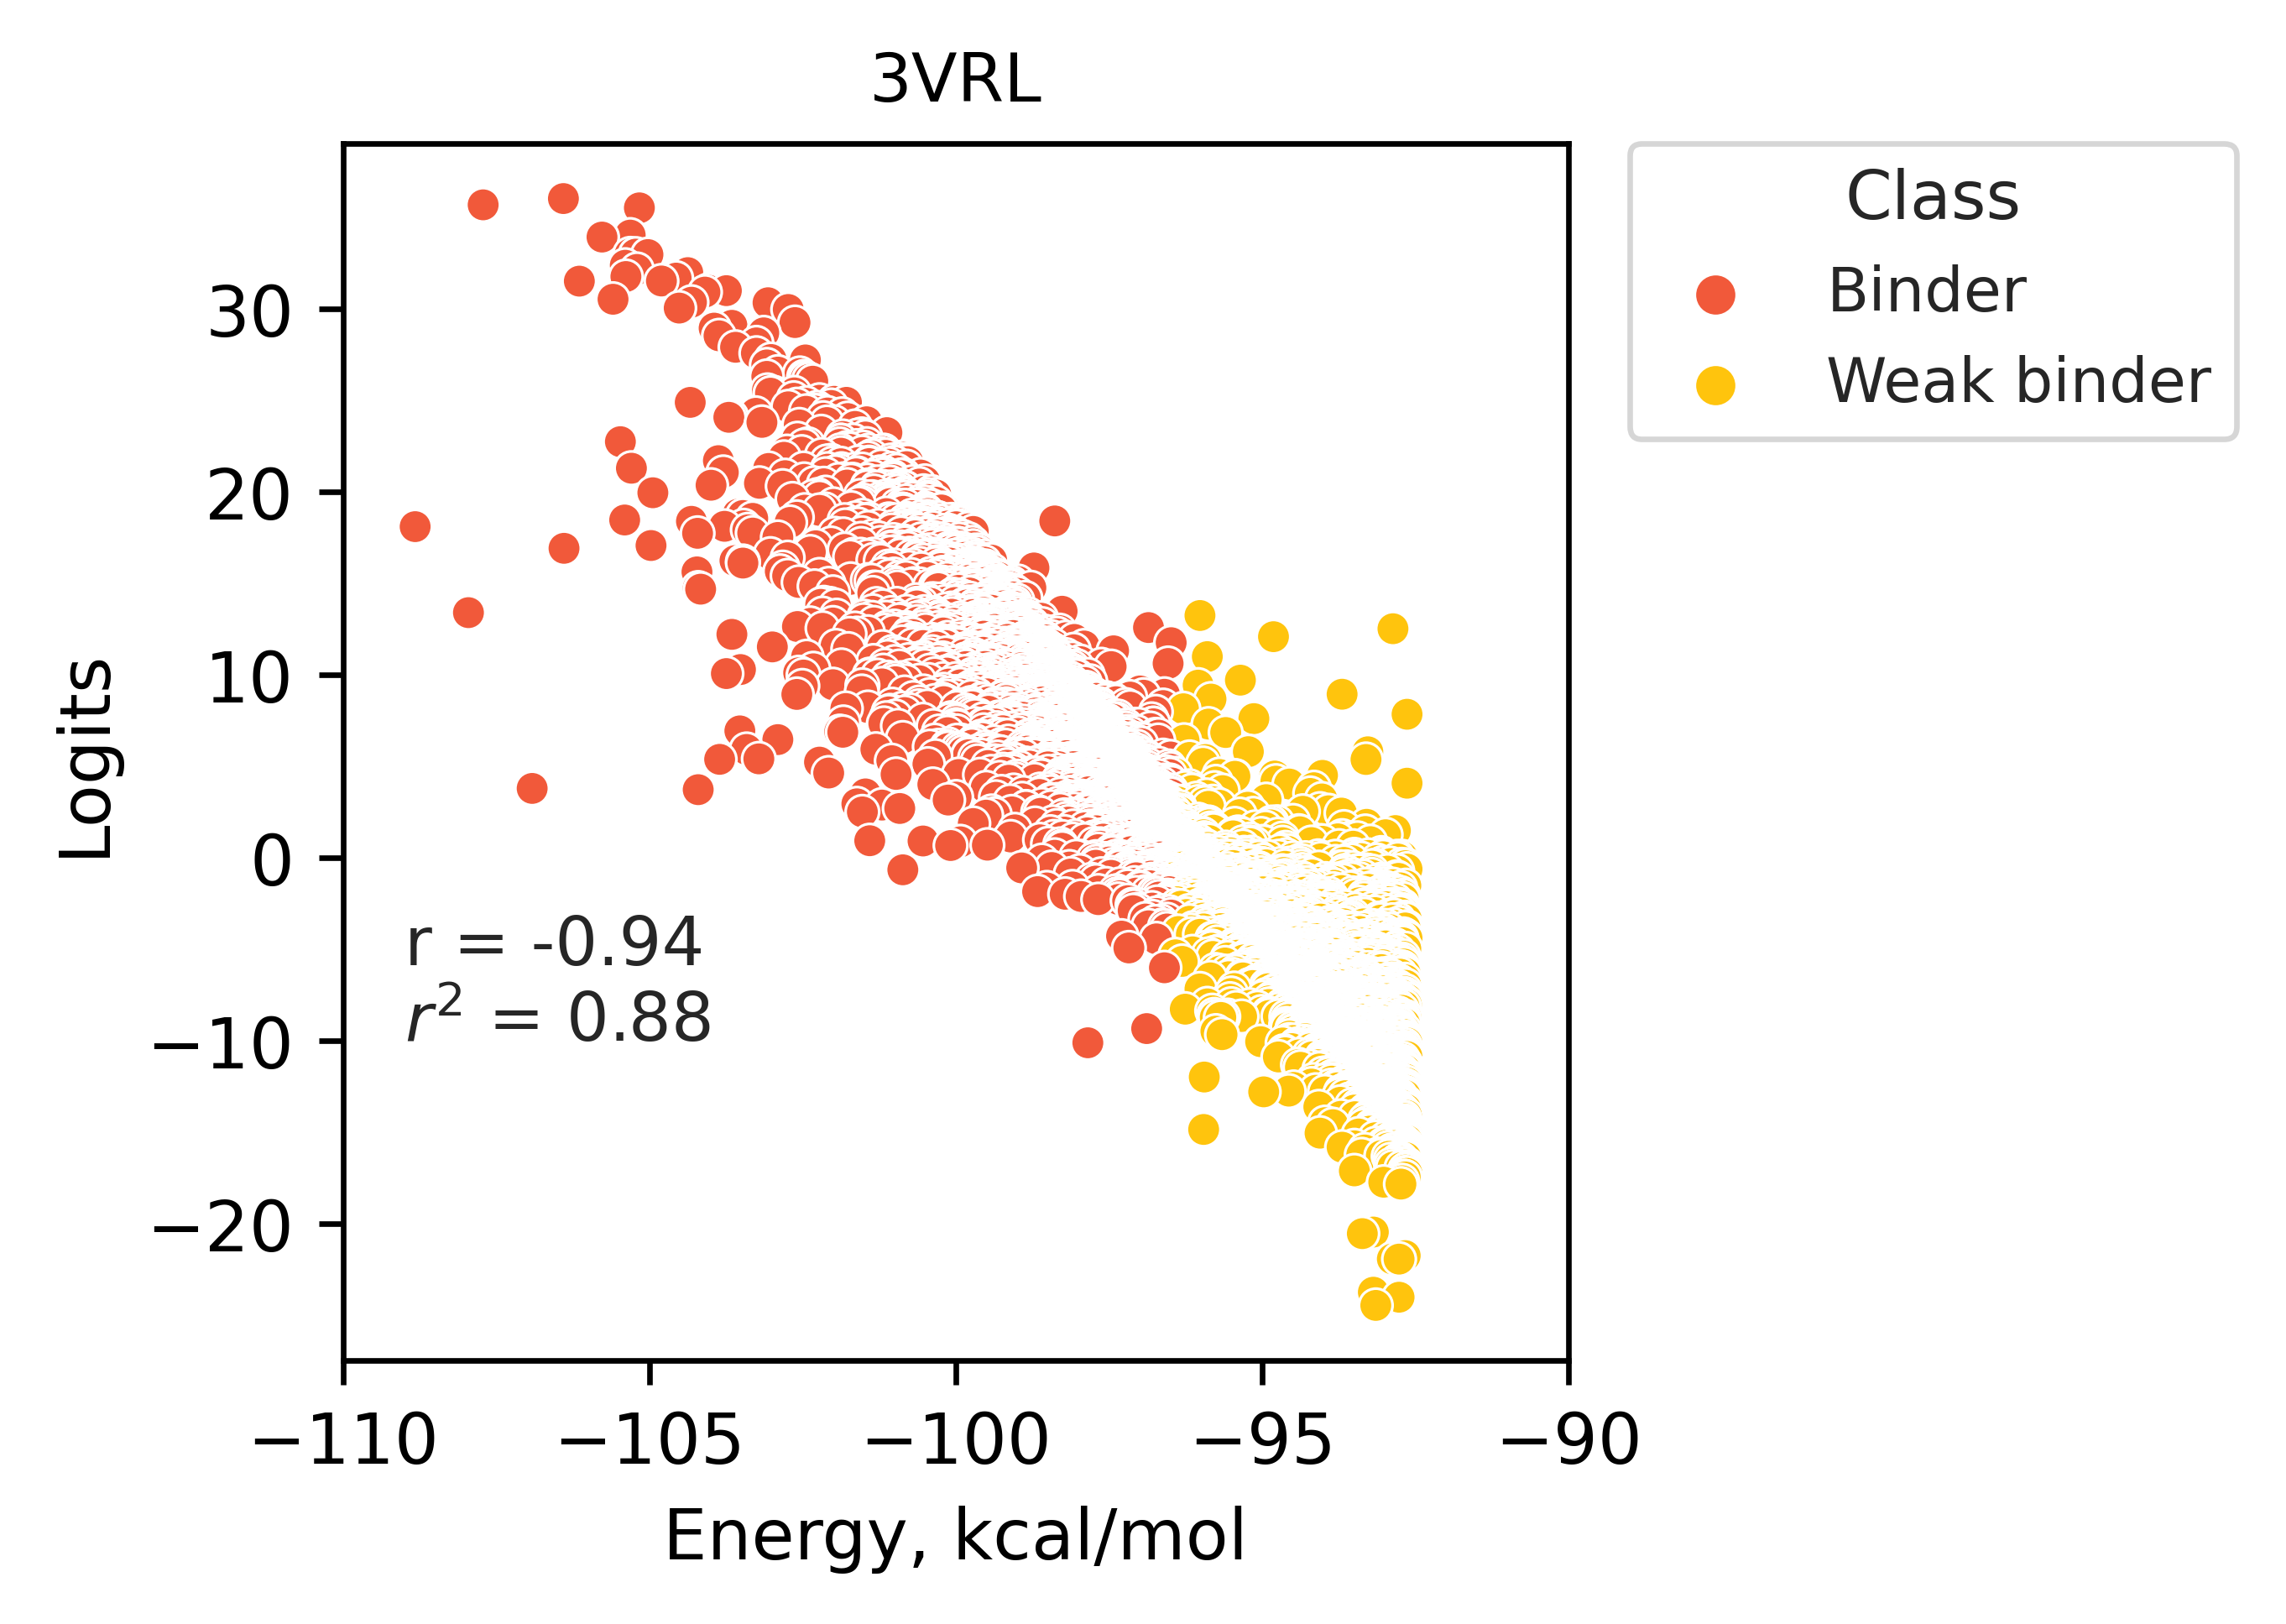

In [5]:
fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = [
    "#f1593a", # red
    "#ffc40d", # yellow
    "#28a3dc", # blue
]

sns.scatterplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
)

# Add legend with legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=["Binder", "Weak binder"],
    title="Class",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0,
)

ax.set_xlabel("Energy, kcal/mol")
ax.set_ylabel("Logits")
ax.set_title("3VRL")
ax.set_xticks(np.arange(-110, -89, 5))

# Add a coefficient of correlation and coeficient of determination
r, p = pearsonr(df["Energy"], df["logits"])
r2 = r ** 2
ax.text(
    -109,
    -10,
    f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
)

Logits ~ Energy

In [6]:
## Functions moved to utils_07. Can be refactored.

from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

def task_generator(task_types=task_types, loader=loader):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task


def get_miniabsolut_dataframes(task, load_energy_contributions=False):
    """Load the dataframes based on MiniAbsolut, from task
    These dataframes contain extra info, such as binding energies.
    """
    if task.split_id == 42:
        miniabsolut_path = Path("../data/MiniAbsolut")
    elif task.split_id in [0, 1, 2, 3, 4]:
        miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed{task.split_id}")
    
    ag_pos_dir = miniabsolut_path / task.ag_pos
    if load_energy_contributions:
        ag_pos_dir = ag_pos_dir / "energy_contributions"
        suffix = "_absolut_energy_contributions"
        header = 1
    else:
        suffix = ""
        header = 0
    
    df_pos = pd.read_csv(ag_pos_dir / f"high_test_5000{suffix}.tsv", sep="\t", header=header)
    df_pos["class"] = "positive"

    if task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
        df_neg = pd.read_csv(ag_pos_dir / f"95low_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        df_neg = pd.read_csv(ag_pos_dir / f"looserX_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type in (datasets.ClassificationTaskType.ONE_VS_ONE, datasets.ClassificationTaskType.ONE_VS_NINE):
        # raise ValueError("Not implemented.")
        df_neg = pd.DataFrame()
    
    df = pd.concat([df_pos, df_neg], axis=0)
    
    return df

In [7]:
logit_energy_corr_path = "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations.tsv"
force_run = False
skip_errors_logits = True

if Path(logit_energy_corr_path).exists() and not force_run:
    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
else:

    records = []
    for task in task_generator():
        
        if skip_errors_logits:
            try:
                task = loader.load(task, attributions_toload="v2.0-2")
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="v2.0-2")

        # Get energies
        df = get_miniabsolut_dataframes(task)

        # Add logits to df
        df_attr = pd.DataFrame.from_records(task.attributions)
        df = pd.merge(df, df_attr[["slide", "logits"]], left_on="Slide", right_on="slide", how='left')

        # Compute correlation and p-val with scipy for all and positive class
        r, p = pearsonr(df["logits"], df["Energy"])
        r_pos, p_pos = pearsonr(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"])

        # Compute slope for all and positive class
        slope, intercept = np.polyfit(df["logits"], df["Energy"], 1)
        slope_pos, intercept_pos = np.polyfit(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"], 1)
        
        records.append({
            "task_type": task.task_type.to_str(),
            "ag_pos": task.ag_pos,
            "ag_neg": task.ag_neg,
            "seed_id": task.seed_id,
            "split_id": task.split_id,
            "r": r,
            "p": p,
            "r2": r**2,
            "r_pos": r_pos,
            "r_pos2": r_pos**2,
            "p_pos": p_pos,
            "slope": slope,
            "intercept": intercept,
            "slope_pos": slope_pos,
            "intercept_pos": intercept_pos,
            "logits_mean": df["logits"].mean(),
            "logits_std": df["logits"].std(),
            "Energy_mean": df["Energy"].mean(),
            "Energy_std": df["Energy"].std(),
            "logits_pos_mean": df[df["class"] == "positive"]["logits"].mean(),
            "logits_pos_std": df[df["class"] == "positive"]["logits"].std(),
            "Energy_pos_mean": df[df["class"] == "positive"]["Energy"].mean(),
            "Energy_pos_std": df[df["class"] == "positive"]["Energy"].std(),
            "logits_neg_mean": df[df["class"] == "negative"]["logits"].mean(),
            "logits_neg_std": df[df["class"] == "negative"]["logits"].std(),
            "Energy_neg_mean": df[df["class"] == "negative"]["Energy"].mean(),
            "Energy_neg_std": df[df["class"] == "negative"]["Energy"].std(),
        })

    df_logits = pd.DataFrame.from_records(records)
    df_logits.to_csv(logit_energy_corr_path, index=False, sep='\t')

In [8]:
# Correcting an error in the collection of the results by merging new and old LogitEnergyCorrelations.
df_logits_old = pd.read_csv("../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations_old.tsv", sep="\t")
df_logits_new = pd.concat(
    [
        df_logits.query("task_type == '1v1'").copy(),
        df_logits_old.query("task_type != '1v1'").copy(),
    ],
    axis=0
)
df_logits_new.task_type.value_counts()
df_logits = df_logits_new.copy()

In [9]:
### No need to do the correction from below, we already computed for both ways!
### Double check: df_logits.query("task_type == '1v1'").query("ag_pos in ['3VRL', '1NSN'] and ag_neg in ['3VRL', '1NSN']")

## Correct for double antigen contribution from 1v1 (to pos and negative, symmetric)
# df_logits_1v1 = df_logits.loc[df_logits["task_type"] == "1v1"].copy()
# ag_pos_series = df_logits_1v1["ag_pos"]
# df_logits_1v1["ag_pos"] = df_logits_1v1["ag_neg"]
# df_logits_1v1["ag_neg"] = ag_pos_series
# del ag_pos_series
# df_logits = pd.concat([df_logits, df_logits_1v1], axis=0)

In [10]:
# fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

# sns.stripplot(data=df_logits, x="task_type", y="logits_pos_mean", hue="ag_pos", ax=ax)

# # Disable legend
# ax.legend_.remove()

# # ax.set_title("Logits mean for positive class")
# ax.set_ylabel("Mean(Logit) for the positive class")
# ax.set_xlabel("Task type")

In [11]:
# sns.stripplot(data=df_logits, x="task_type", y="Energy_pos_mean", hue="ag_pos")

In [12]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
1v1            -0.613358 -0.047297  0.319436
1v9            -0.771730 -0.192282  0.204192
high_vs_95low  -0.846448 -0.506698 -0.286192
high_vs_looser -0.897692 -0.615479 -0.326624

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_834887/2258301069.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

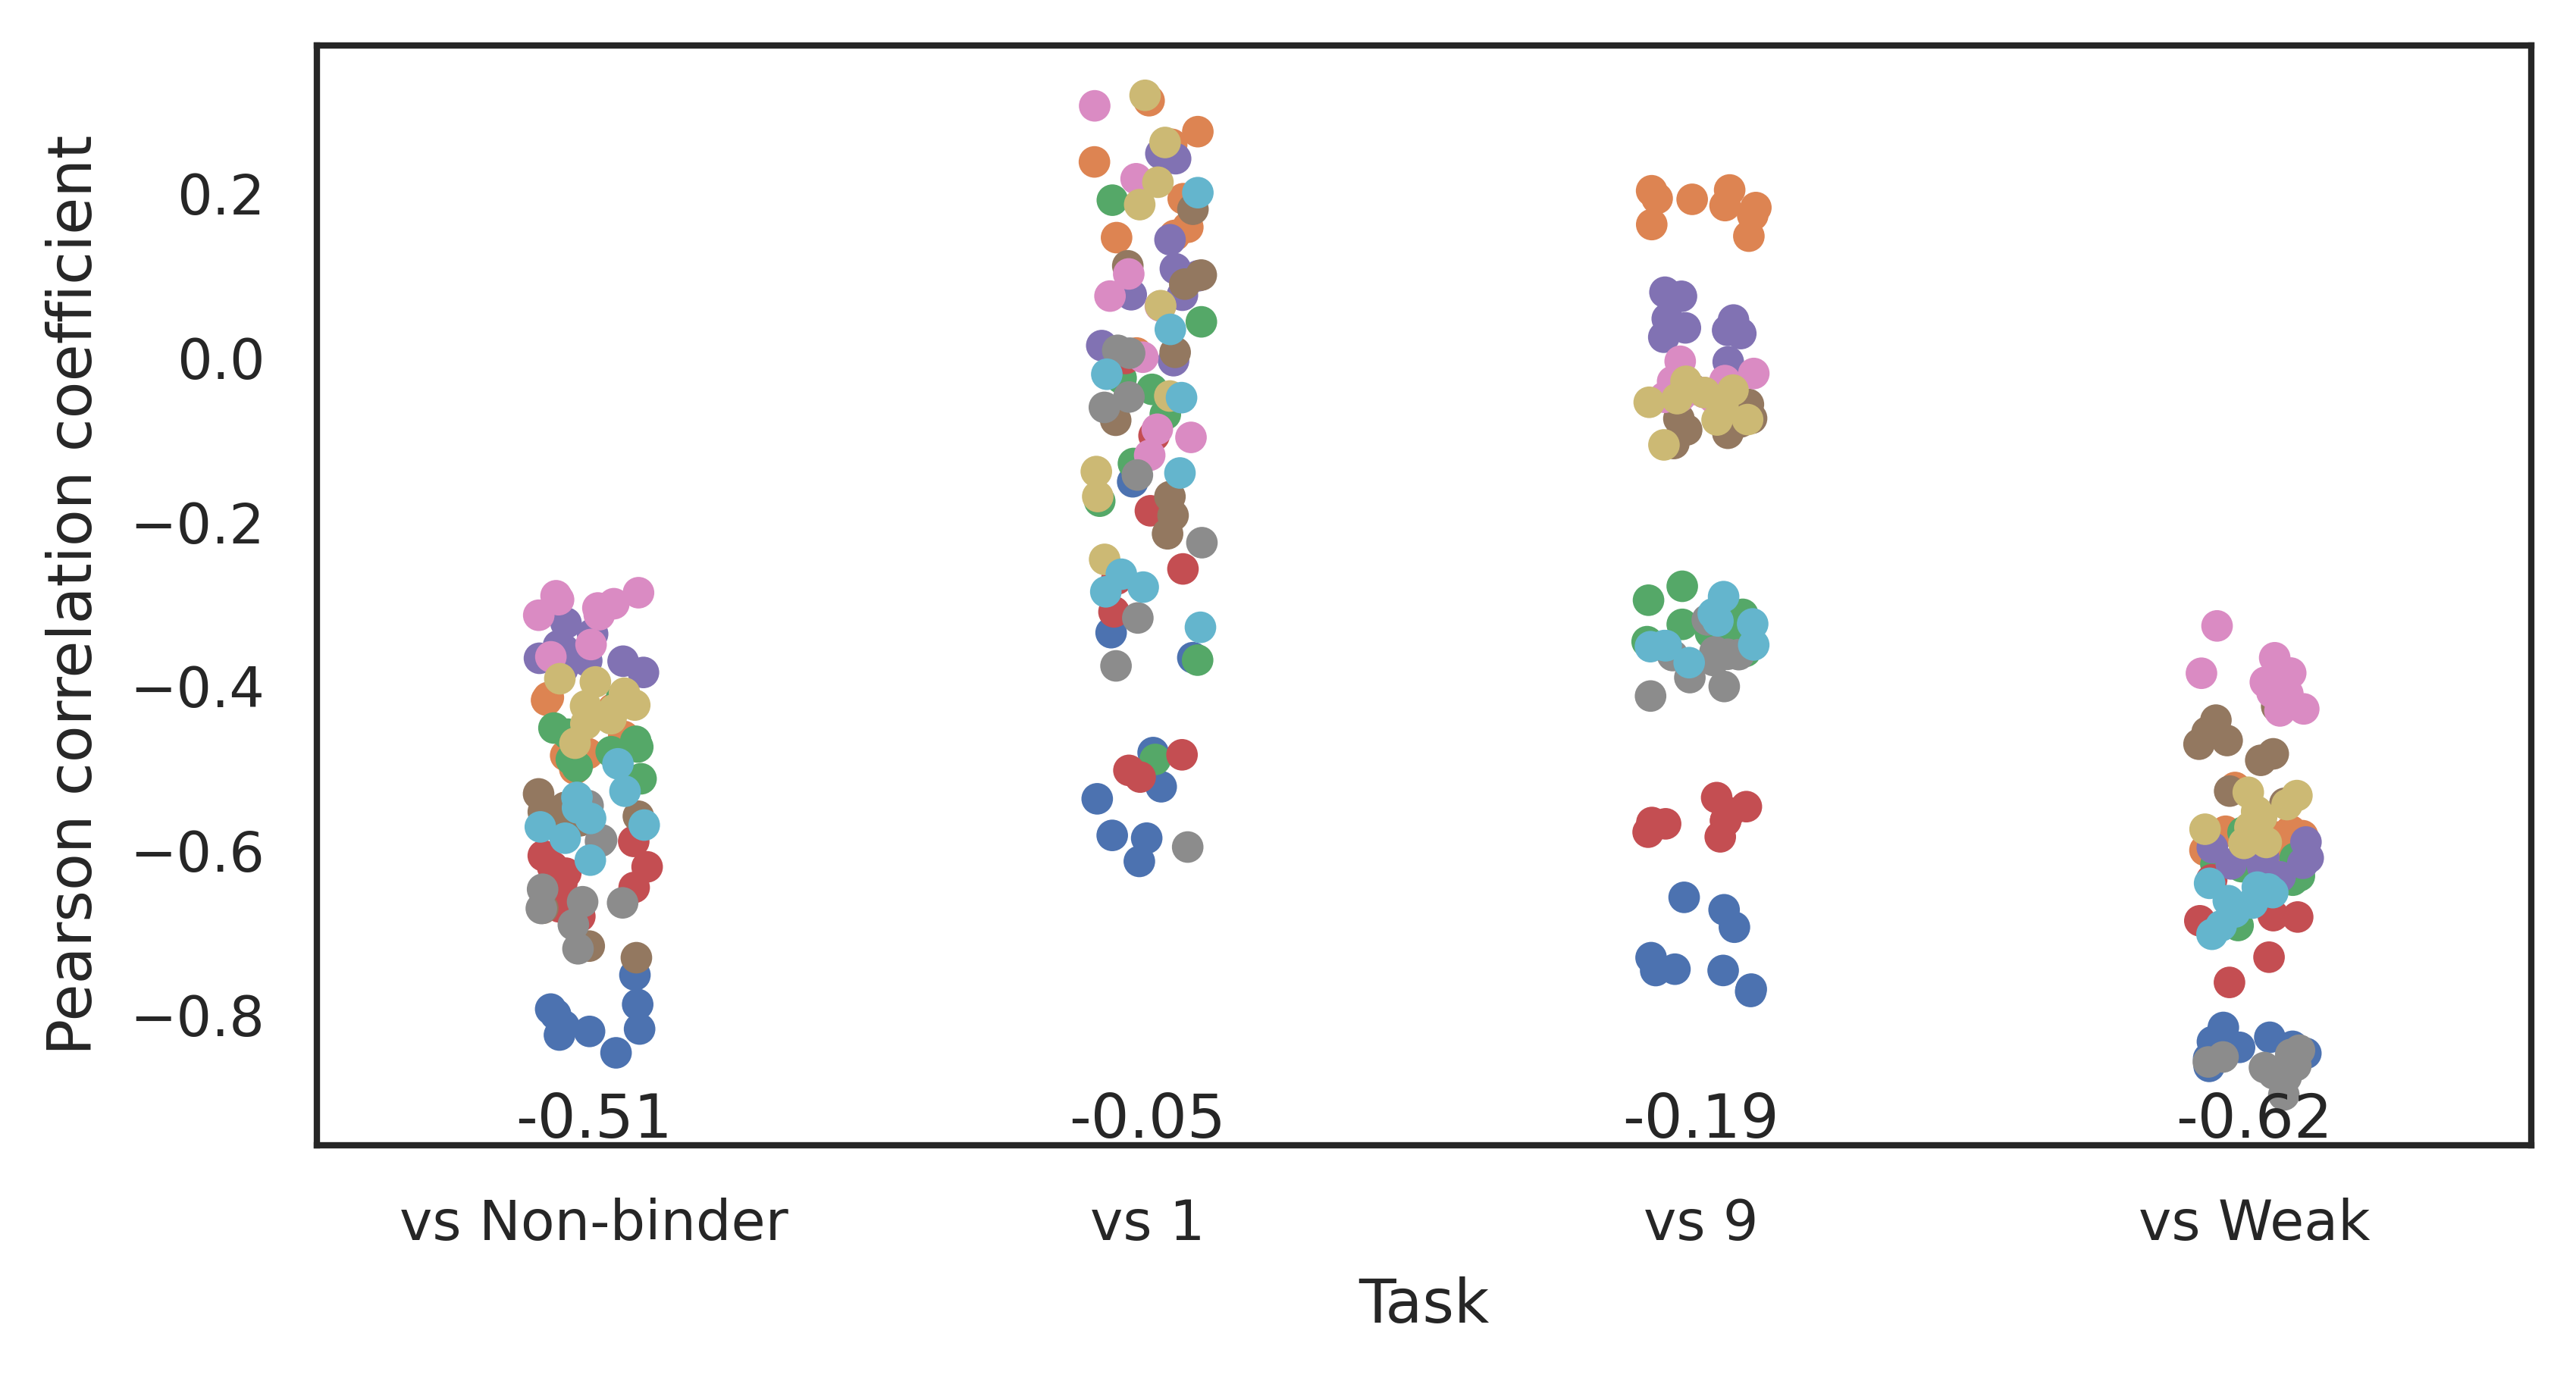

In [13]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos", 
    hue="ag_pos", 
    ax=ax, 
    cmap=visualisations.PlotParams.cmap_antigens,
    order=task_order,
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.95,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [14]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_logits.query("task_type == 'high_vs_95low'")["r_pos"],
    df_logits.query("task_type == '1v1'")["r_pos"],
    df_logits.query("task_type == '1v9'")["r_pos"],
    df_logits.query("task_type == 'high_vs_looser'")["r_pos"],
)

F_onewayResult(statistic=132.9461919297828, pvalue=8.73375238666368e-58)

In [15]:
# Associations with linear performance
df_acc = pd.read_csv("../data/Frozen_MiniAbsolut_ML/df_task_data_processed.tsv", sep='\t')
df_acc.head()

seed_id  split_id task_type ag_pos ag_neg  acc_closed model_type
0        0         0       1v1   1ADQ   1FBI    0.977471       SN10
1        0         0       1v1   1ADQ   1H0D    0.974257       SN10
2        0         0       1v1   1ADQ   1NSN    0.973757       SN10
3        0         0       1v1   1ADQ   1OB1    0.976157       SN10
4        0         0       1v1   1ADQ   1WEJ    0.967686       SN10

In [16]:
# Define a task column. If task_type 1v1, then ag_pos, ag_neg follow alphanumeric sorting.
def define_task_col(df):
    tasks = []
    for i, row in df.iterrows():
        if row["task_type"] == "1v1":
            ag_1, ag_2 = tuple(sorted([row["ag_pos"], row["ag_neg"]]))
        else:
            ag_1 = row["ag_pos"]
            ag_2 = row["ag_neg"]
        
        if "_" in ag_1:
            ag_1 = ag_1.split("_")[0]

        if "_" in ag_2:
            ag_2 = ag_2.split("_")[0]
        
        if row["task_type"] == "1v9":
            ag_2 = "v9"
        elif ag_2 == "auto" and row["task_type"] != "1v9":
            ag_2 = ag_1

        task = f"{row['task_type']}_{ag_1}_{ag_2}"
        tasks.append(task)

    df["task"] = tasks


define_task_col(df_logits)
define_task_col(df_acc)

In [17]:
# Aggregate acc based on task
df_acc_agg = df_acc.groupby(["task", "task_type"]).agg({"acc_closed": "mean"}).reset_index()

# Aggregate logits correlation based on task
df_logits_agg = df_logits.groupby(["task", "task_type"]).agg({"r_pos": "mean"}).reset_index()

# Merge
df_merged = pd.merge(df_acc_agg, df_logits_agg, on=["task", "task_type"], how='inner')

<AxesSubplot: xlabel='acc_closed', ylabel='r_pos'>

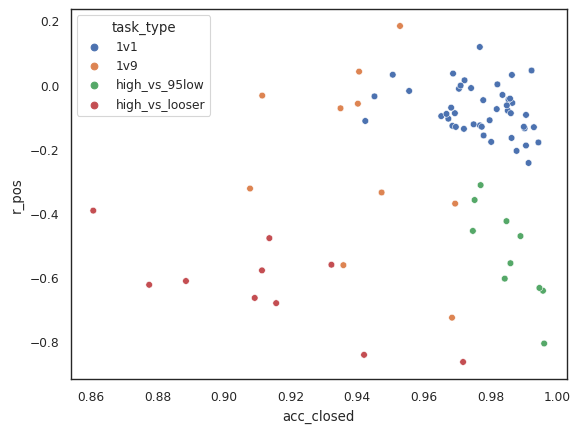

In [18]:
sns.scatterplot(
    data=df_merged,
    x="acc_closed",
    y="r_pos",
    hue="task_type",
)

In [19]:
df_merged

task       task_type  acc_closed     r_pos
0              1v1_1ADQ_1FBI             1v1    0.977923 -0.158201
1              1v1_1ADQ_1H0D             1v1    0.974163 -0.010504
2              1v1_1ADQ_1NSN             1v1    0.972200  0.013661
3              1v1_1ADQ_1OB1             1v1    0.976816 -0.126659
4              1v1_1ADQ_1WEJ             1v1    0.968755  0.034684
..                       ...             ...         ...       ...
70  high_vs_looser_1WEJ_1WEJ  high_vs_looser    0.913621 -0.477966
71  high_vs_looser_2YPV_2YPV  high_vs_looser    0.932250 -0.560745
72  high_vs_looser_3RAJ_3RAJ  high_vs_looser    0.877557 -0.623275
73  high_vs_looser_3VRL_3VRL  high_vs_looser    0.942043 -0.841433
74  high_vs_looser_5E94_5E94  high_vs_looser    0.915668 -0.680337

[75 rows x 4 columns]

vs 1
vs 9
vs Non-binder
vs Weak


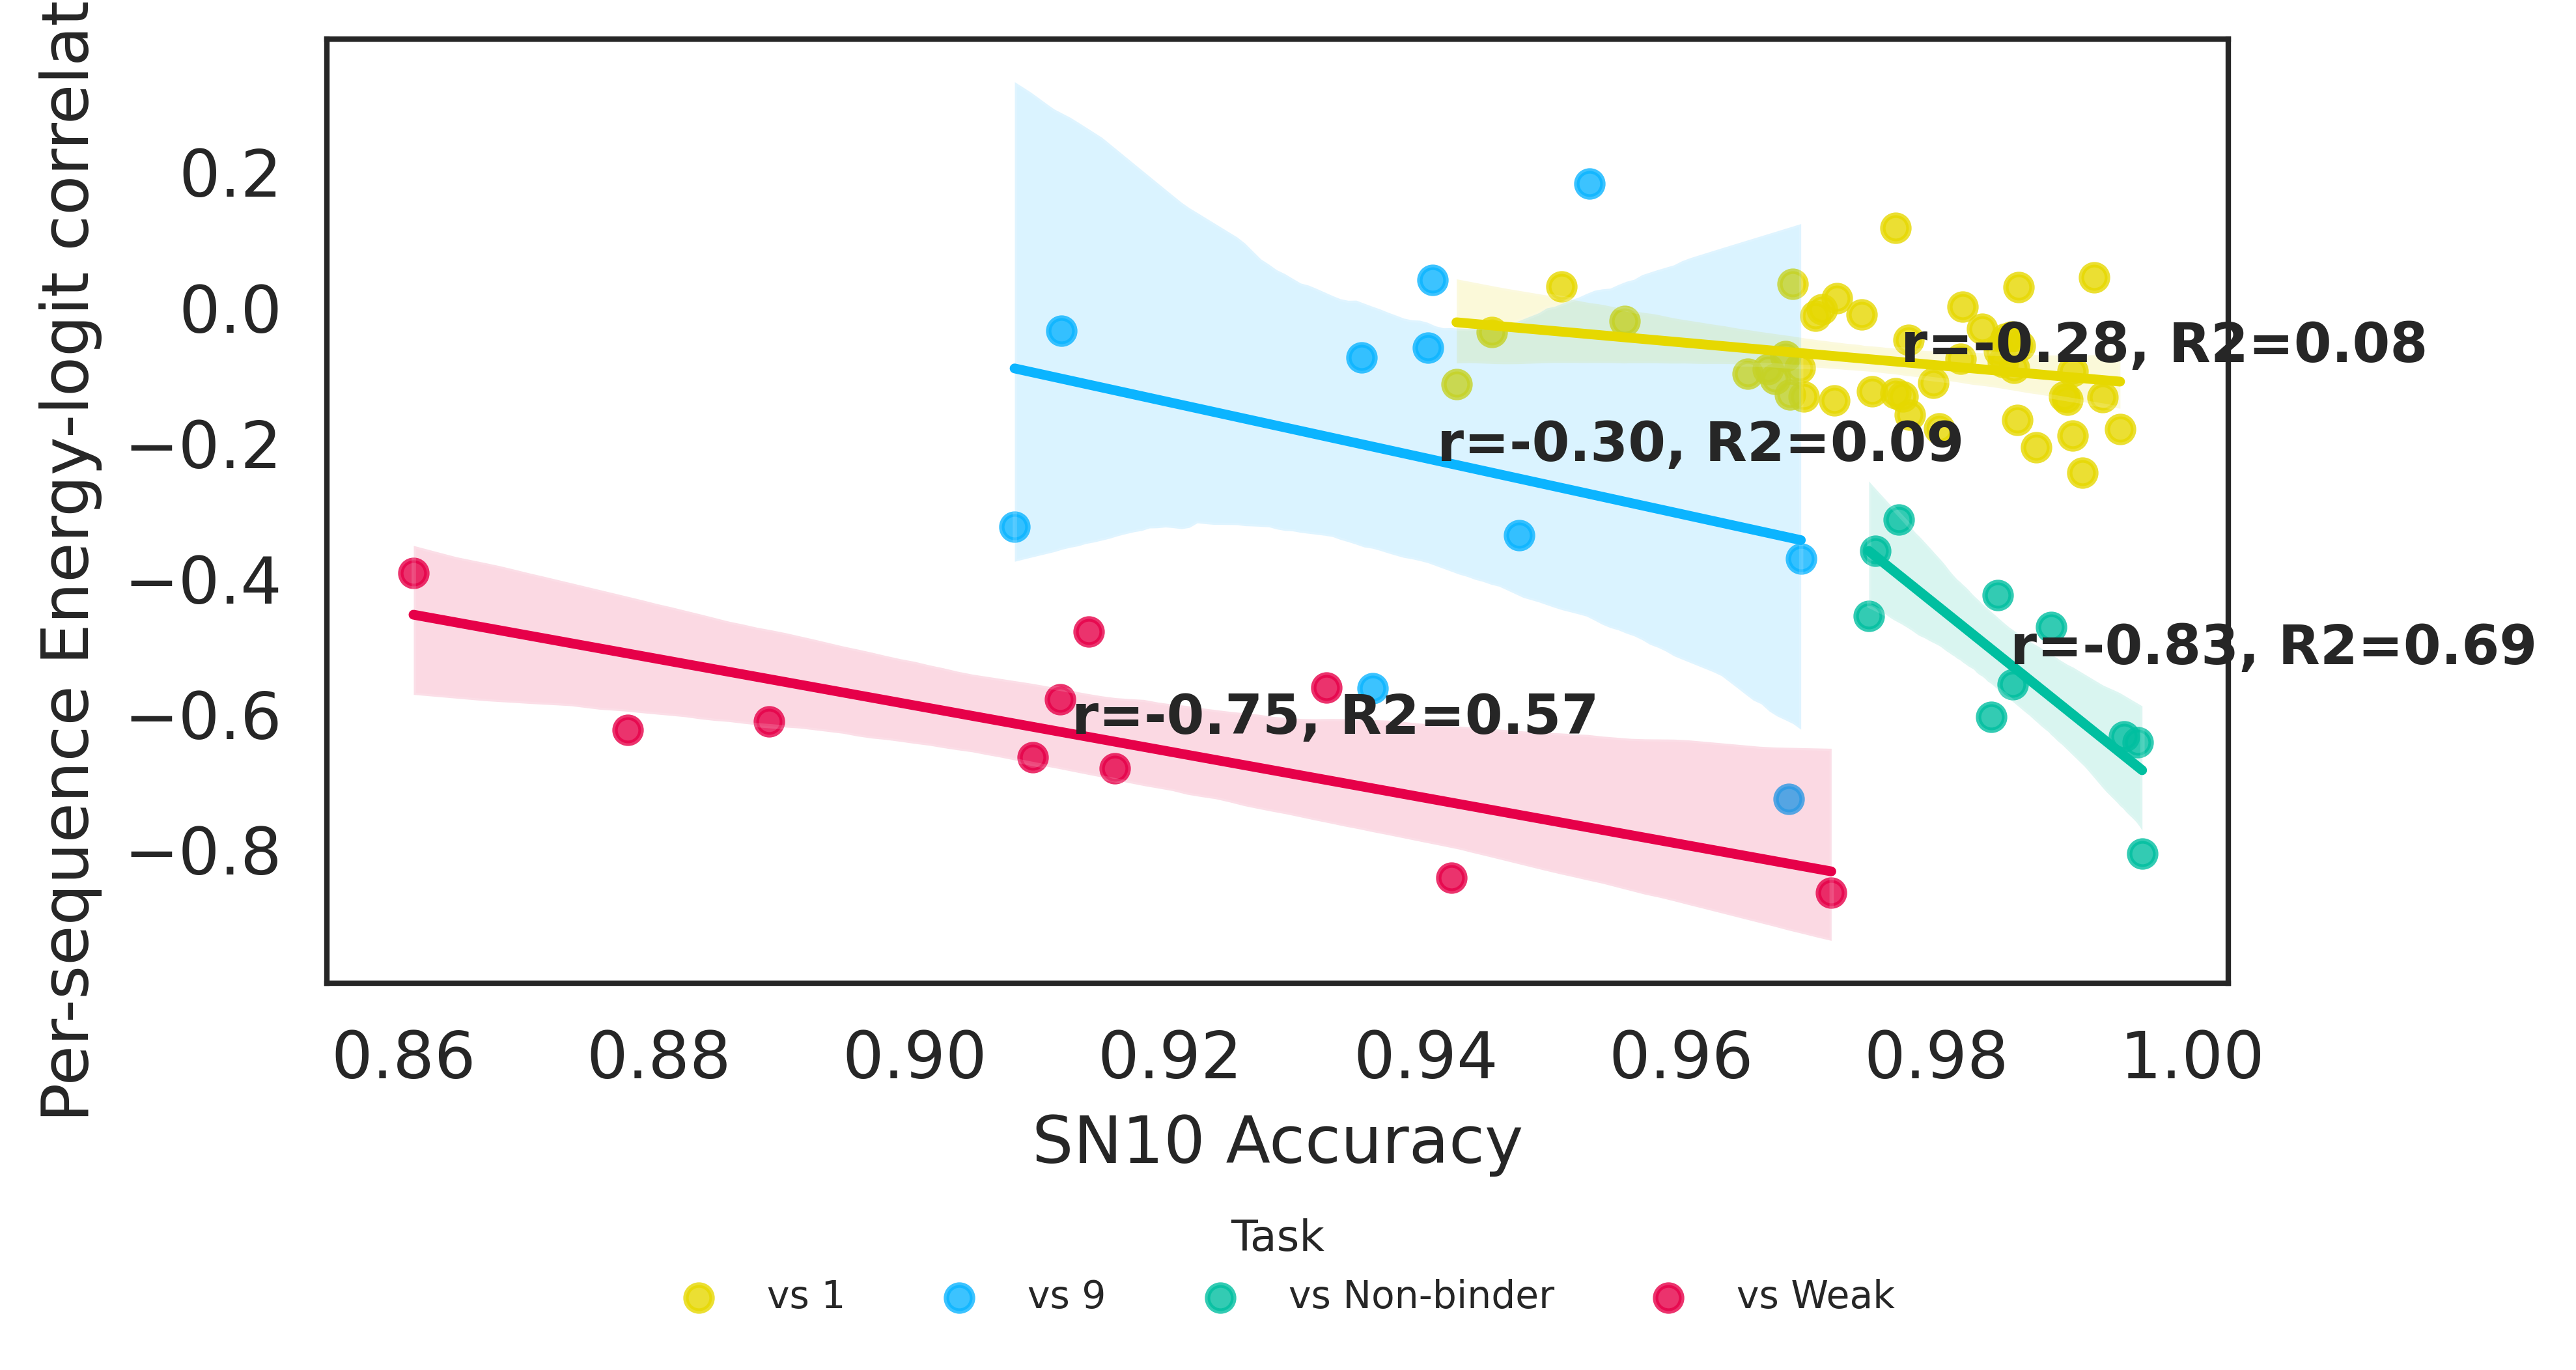

In [20]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Map to tasks clean
df_merged["task_type_clean"] = df_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# Line plot in seaborn with R2 regression
for i, df_g in df_merged.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="acc_closed",
        y="r_pos",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["r_pos"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    y = df_g["r_pos"].mean()
    x = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_ylabel("Per-sequence Energy-logit correlation", fontsize=FONT_SIZE)
ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

# ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

# fig.savefig("figures/1B.svg")
fig.show()

In [21]:
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.boxplot(data=df_logits, x="task_type", y="r_pos", hue="ag_pos", ax=ax)
# ax.set_title("Correlation between logits and binding energy for MiniAbsolut tasks")

In [22]:
# Logits pos mean and logits ~ energy correlation rank relation
# Low
df_logits.groupby(["task_type", "ag_pos"])[["logits_pos_mean", "r_pos"]].mean().corr()

logits_pos_mean     r_pos
logits_pos_mean         1.000000  0.310216
r_pos                   0.310216  1.000000

Energy contributions ~ Attributions correlations

In [23]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version
from utils_07 import get_attr_from_records, get_onehotstack_from_records

In [24]:
energy_contributions_path = "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions.tsv"
# energy_contributions_path = "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions_1v1.tsv"
force_run_contrib = False
skip_errors_contrib = True

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:

    records = []
    # for task in task_generator():
    for task in task_generator():
        
        if skip_errors_contrib:
            try:
                stats = load_energy_contributions_from_task_nonlinear_version(task)
            except:
                continue
        else:
            stats = load_energy_contributions_from_task_nonlinear_version(task)
        
        records.append(stats)

    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

In [25]:
df_attrib

task_type ag_pos ag_neg  seed_id  split_id      mean       std  \
0               1v1   3VRL   1NSN        0        42 -0.625605  0.157186   
1               1v1   3VRL   3RAJ        0        42 -0.415575  0.209052   
2               1v1   3VRL   5E94        0        42  0.002736  0.239668   
3               1v1   3VRL   1H0D        0        42 -0.615945  0.121352   
4               1v1   3VRL   1WEJ        0        42 -0.547776  0.151417   
..              ...    ...    ...      ...       ...       ...       ...   
355   high_vs_95low   1OB1   auto        0         3 -0.639203  0.161110   
356  high_vs_looser   1OB1   auto        0         3 -0.666125  0.130758   
357             1v9   1OB1   auto        0         4 -0.494782  0.171121   
358   high_vs_95low   1OB1   auto        0         4 -0.614584  0.168696   
359  high_vs_looser   1OB1   auto        0         4 -0.658291  0.131655   

     mean_pos   std_pos  mean_neg  ...  mean_pos_fold  std_pos_fold  \
0   -0.625605  0.157186       NaN  ...       0.099006      0.279813   
1   -0.415575  0.209052       NaN  ...       0.029552      0.233966   
2    0.002736  0.239668       NaN  ...       0.272741      0.217447   
3   -0.615945  0.121352       NaN  ...       0.200372      0.192410   
4   -0.547776  0.151417       NaN  ...       0.035836      0.217605   
..        ...       ...       ...  ...            ...           ...   
355 -0.721276  0.093811 -0.557130  ...       0.075546      0.206941   
356 -0.705792  0.106121 -0.626458  ...       0.050181      0.196527   
357 -0.494782  0.171121       NaN  ...       0.058568      0.215740   
358 -0.690016  0.116593 -0.539152  ...       0.060808      0.210742   
359 -0.693470  0.110050 -0.623112  ...       0.051444      0.204166   

     mean_neg_fold  std_neg_fold  mean_total  std_total  mean_pos_total  \
0              NaN           NaN   -0.597005   0.129539       -0.597005   
1              NaN           NaN   -0.404372   0.219243       -0.404372   
2              NaN           NaN    0.091077   0.239068        0.091077   
3              NaN           NaN   -0.548198   0.115280       -0.548198   
4              NaN           NaN   -0.532763   0.169650       -0.532763   
..             ...           ...         ...        ...             ...   
355      -0.087413      0.280589   -0.678161   0.140350       -0.732303   
356      -0.011806      0.227736   -0.691302   0.130423       -0.720818   
357            NaN           NaN   -0.498989   0.182962       -0.498989   
358      -0.090317      0.285501   -0.654919   0.152718       -0.703149   
359      -0.019130      0.228325   -0.683844   0.135825       -0.707012   

     std_pos_total  mean_neg_total  std_neg_total  
0         0.129539             NaN            NaN  
1         0.219243             NaN            NaN  
2         0.239068             NaN            NaN  
3         0.115280             NaN            NaN  
4         0.169650             NaN            NaN  
..             ...             ...            ...  
355       0.102957       -0.624019       0.151447  
356       0.117537       -0.661785       0.135890  
357       0.182962             NaN            NaN  
358       0.128305       -0.606688       0.159796  
359       0.126784       -0.660676       0.140545  

[360 rows x 23 columns]

In [26]:
## As above for the logits case, no need to duplicate for 1v1, since
##  we already have computed the associations for both ways!
## Double check with:
# df_attrib.query("task_type == '1v1'").query("ag_pos in ['3VRL', '1NSN'] and ag_neg in ['3VRL', '1NSN']")


# # Duplicate 1v1 and reverse pos with negative to account for double contributions
# df_attrib_1v1 = df_attrib.loc[df_attrib["task_type"] == "ONE_VS_ONE"].copy()
# ag_pos_col = df_attrib_1v1["ag_pos"]
# df_attrib_1v1["ag_pos"] = df_attrib_1v1["ag_neg"]
# df_attrib_1v1["ag_neg"] = ag_pos_col
# del ag_pos_col

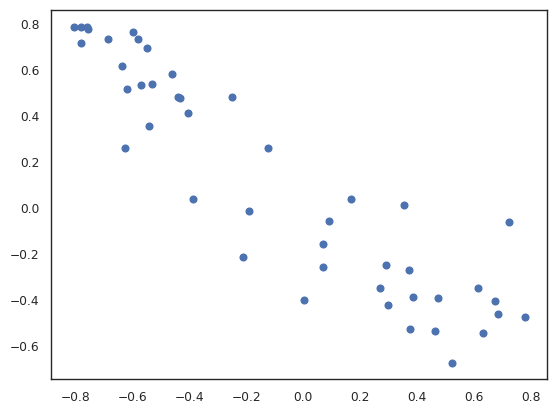

In [27]:
## There is a pattern for 1v1 when one looks at the correlation between forward and backwards, there is antisymmetry!

from itertools import combinations

df_attrib_1v1 = df_attrib.query("task_type == '1v1'").copy()
ags = df_attrib_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_attrib_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").mean_pos_total.median()
    r_bwd = df_attrib_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").mean_pos_total.median()
    res.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
    })

plt.plot([r["r_fwd"] for r in res], [r["r_bwd"] for r in res], 'o')

In [28]:
# sns.catplot(
#     data=df_attrib, 
#     x="task_type", 
#     y="mean_pos", 
#     hue="ag_pos")

In [29]:
# sns.catplot(
#     data=df_attrib, 
#     x="task_type", 
#     y="std", 
#     hue="ag_pos")

In [30]:
# # Combined plots from logits and contributions
# df_logits["corr_type"] = "logits"

# df_attrib["corr_type"] = "attributions"
# df_attrib["r_pos"] = df_attrib["mean_pos"]

# df_combined = pd.concat([df_logits, df_attrib])

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.boxplot(data=df_combined, x="task_type", y="r_pos", hue="corr_type", ax=ax)

In [31]:
# df_combined["type"] = df_combined["task_type"] + "_" + df_combined["corr_type"]

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.stripplot(
#     data=df_combined, 
#     x="type", 
#     y="r_pos", 
#     hue="ag_pos",
#     order= [
#         "1v1_logits", "1v1_attributions", "1v9_logits", "1v9_attributions",
#         "high_vs_95low_logits", "high_vs_95low_attributions", "high_vs_looser_logits", "high_vs_looser_attributions"
#     ],
#     jitter=0.2,
#     ax=ax,
# )
# # Rotate x-axis labels 90
# for item in ax.get_xticklabels():
#     item.set_rotation(90)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_834887/1171396604.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

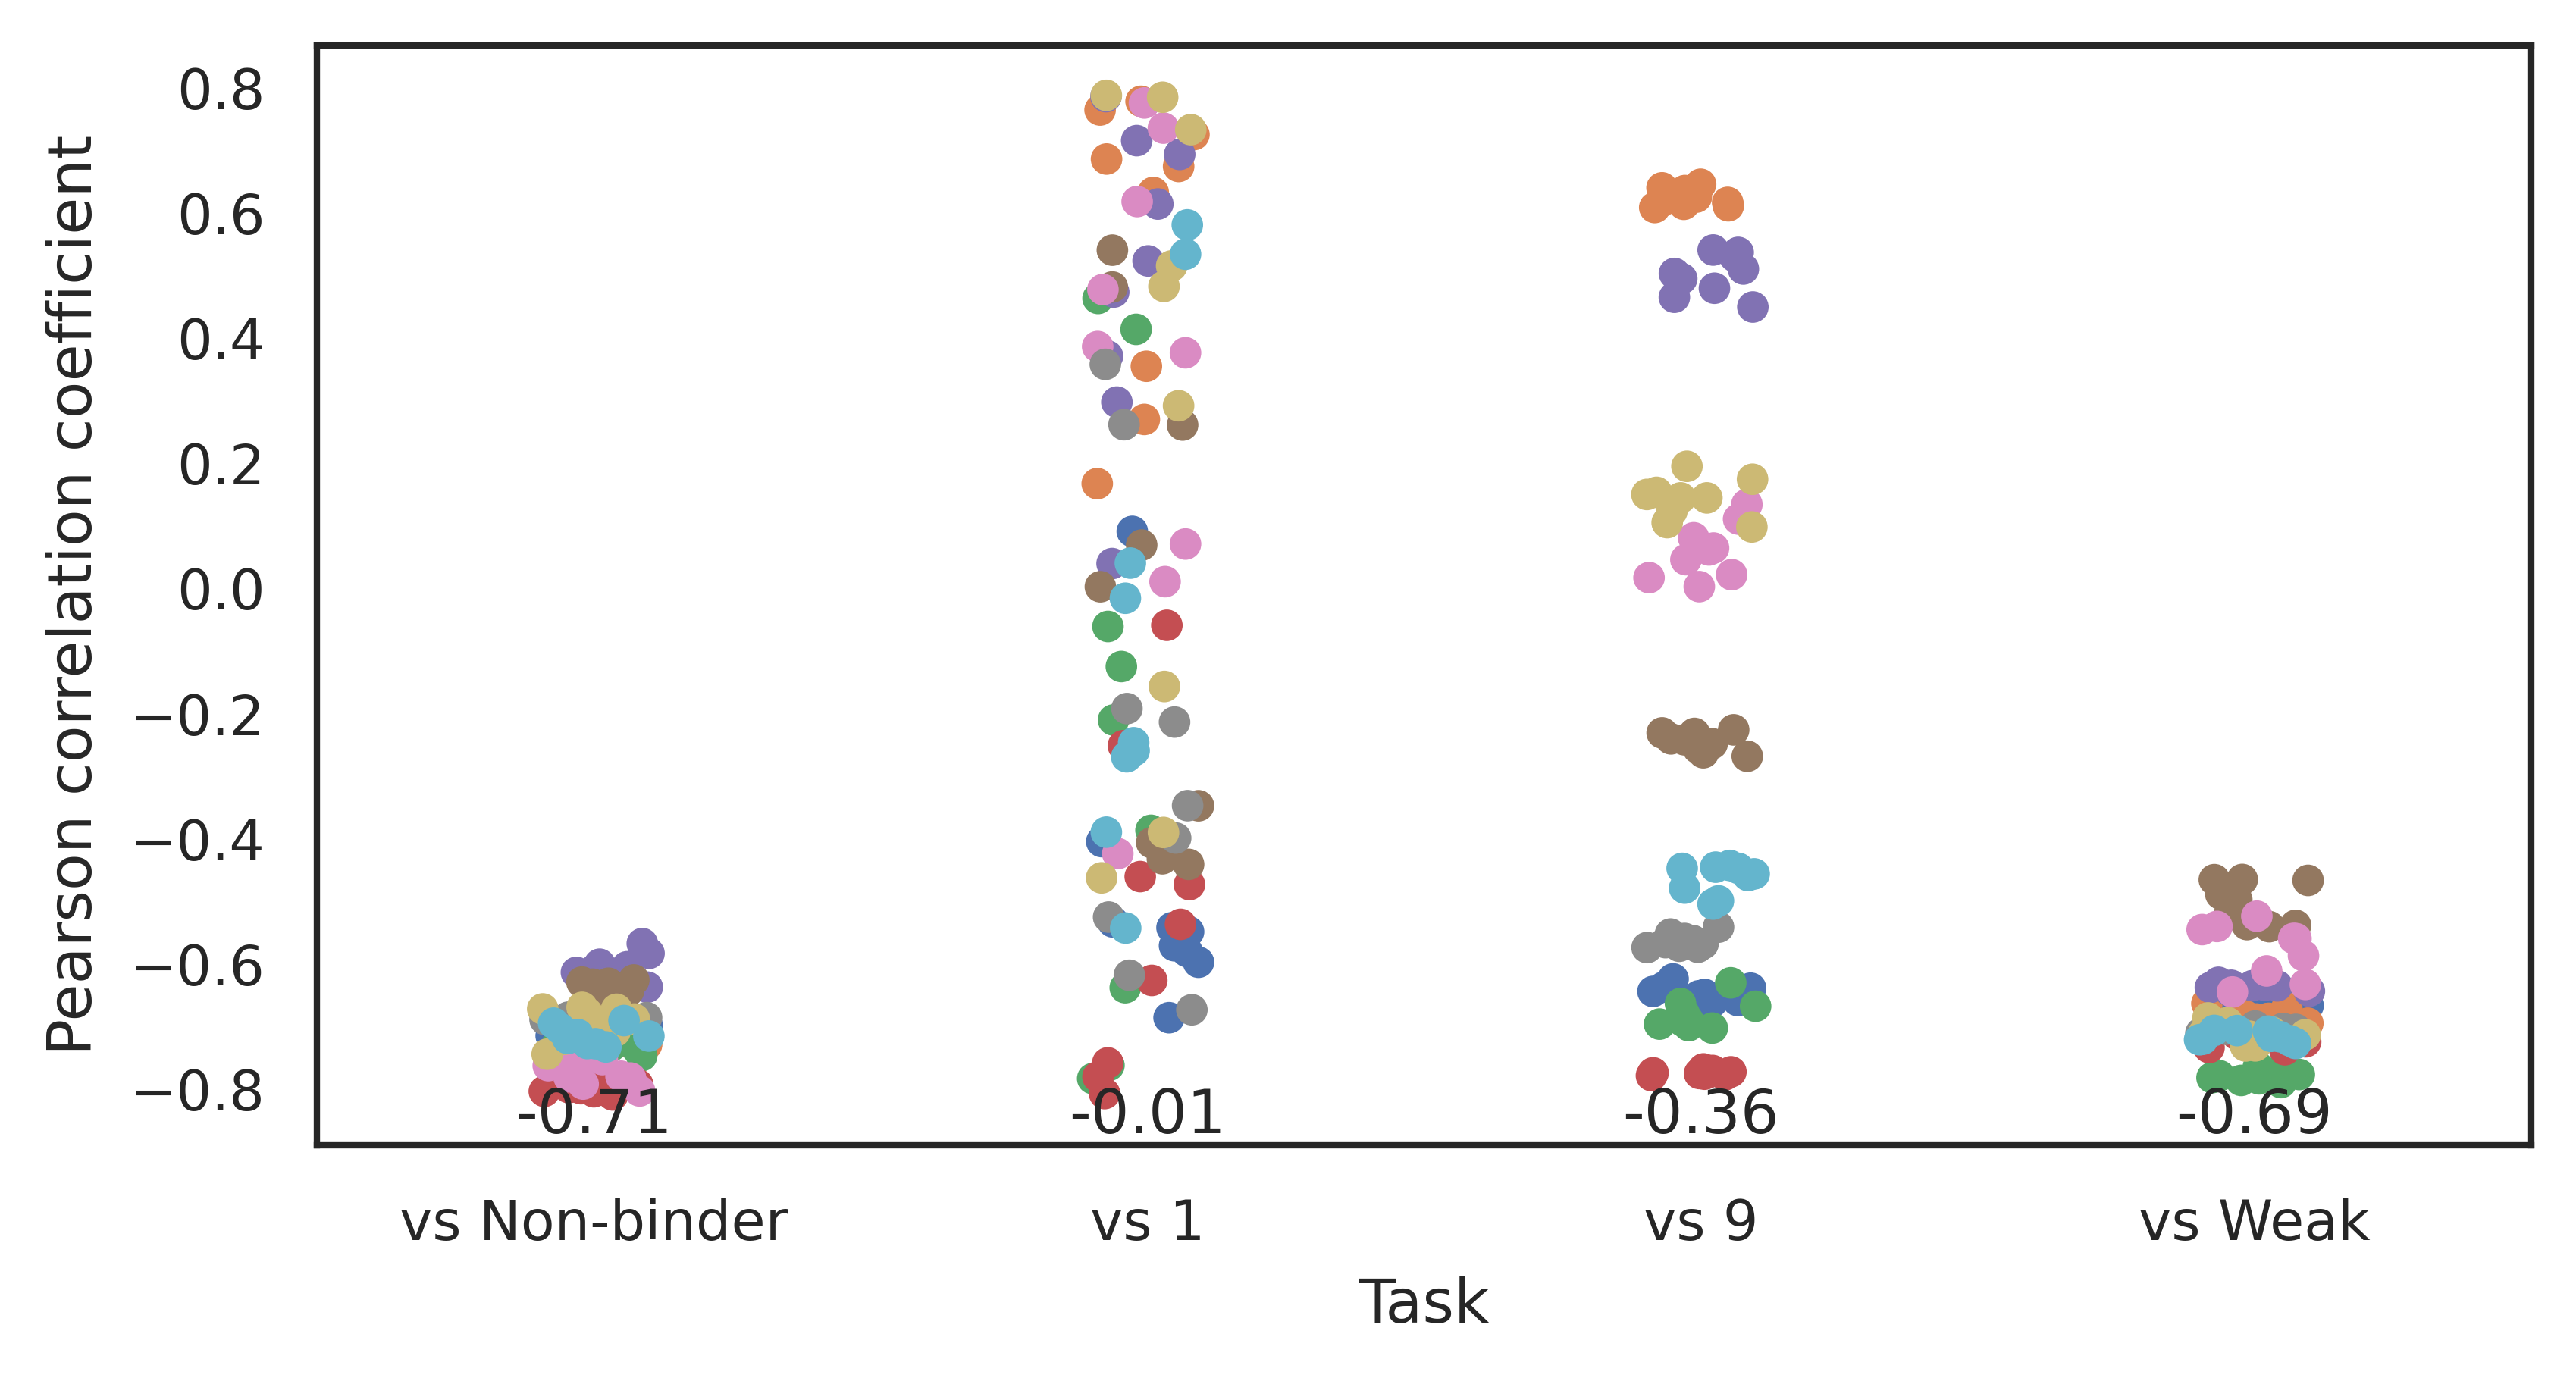

In [32]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    cmap=visualisations.PlotParams.cmap_antigens,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [33]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_attrib.query("task_type == 'high_vs_95low'")["mean_pos_total"],
    df_attrib.query("task_type == '1v1'")["mean_pos_total"],
    df_attrib.query("task_type == '1v9'")["mean_pos_total"],
    df_attrib.query("task_type == 'high_vs_looser'")["mean_pos_total"],
)

F_onewayResult(statistic=89.49635559411753, pvalue=3.5608781432908586e-43)

In [34]:
define_task_col(df_attrib)
df_attrib_agg = df_attrib.groupby(["task", "task_type"]).agg({"mean_pos_total": "mean"}).reset_index()
df_contributions_merged = pd.merge(df_acc_agg, df_attrib_agg, on=["task", "task_type"], how='inner')
df_contributions_merged

task       task_type  acc_closed  mean_pos_total
0              1v1_1ADQ_1FBI             1v1    0.977923       -0.074271
1              1v1_1ADQ_1H0D             1v1    0.974163       -0.062995
2              1v1_1ADQ_1NSN             1v1    0.972200        0.182819
3              1v1_1ADQ_1OB1             1v1    0.976816       -0.001490
4              1v1_1ADQ_1WEJ             1v1    0.968755        0.022812
..                       ...             ...         ...             ...
70  high_vs_looser_1WEJ_1WEJ  high_vs_looser    0.913621       -0.502038
71  high_vs_looser_2YPV_2YPV  high_vs_looser    0.932250       -0.709133
72  high_vs_looser_3RAJ_3RAJ  high_vs_looser    0.877557       -0.778657
73  high_vs_looser_3VRL_3VRL  high_vs_looser    0.942043       -0.675531
74  high_vs_looser_5E94_5E94  high_vs_looser    0.915668       -0.722551

[75 rows x 4 columns]

vs 1
vs 9
vs Non-binder
vs Weak


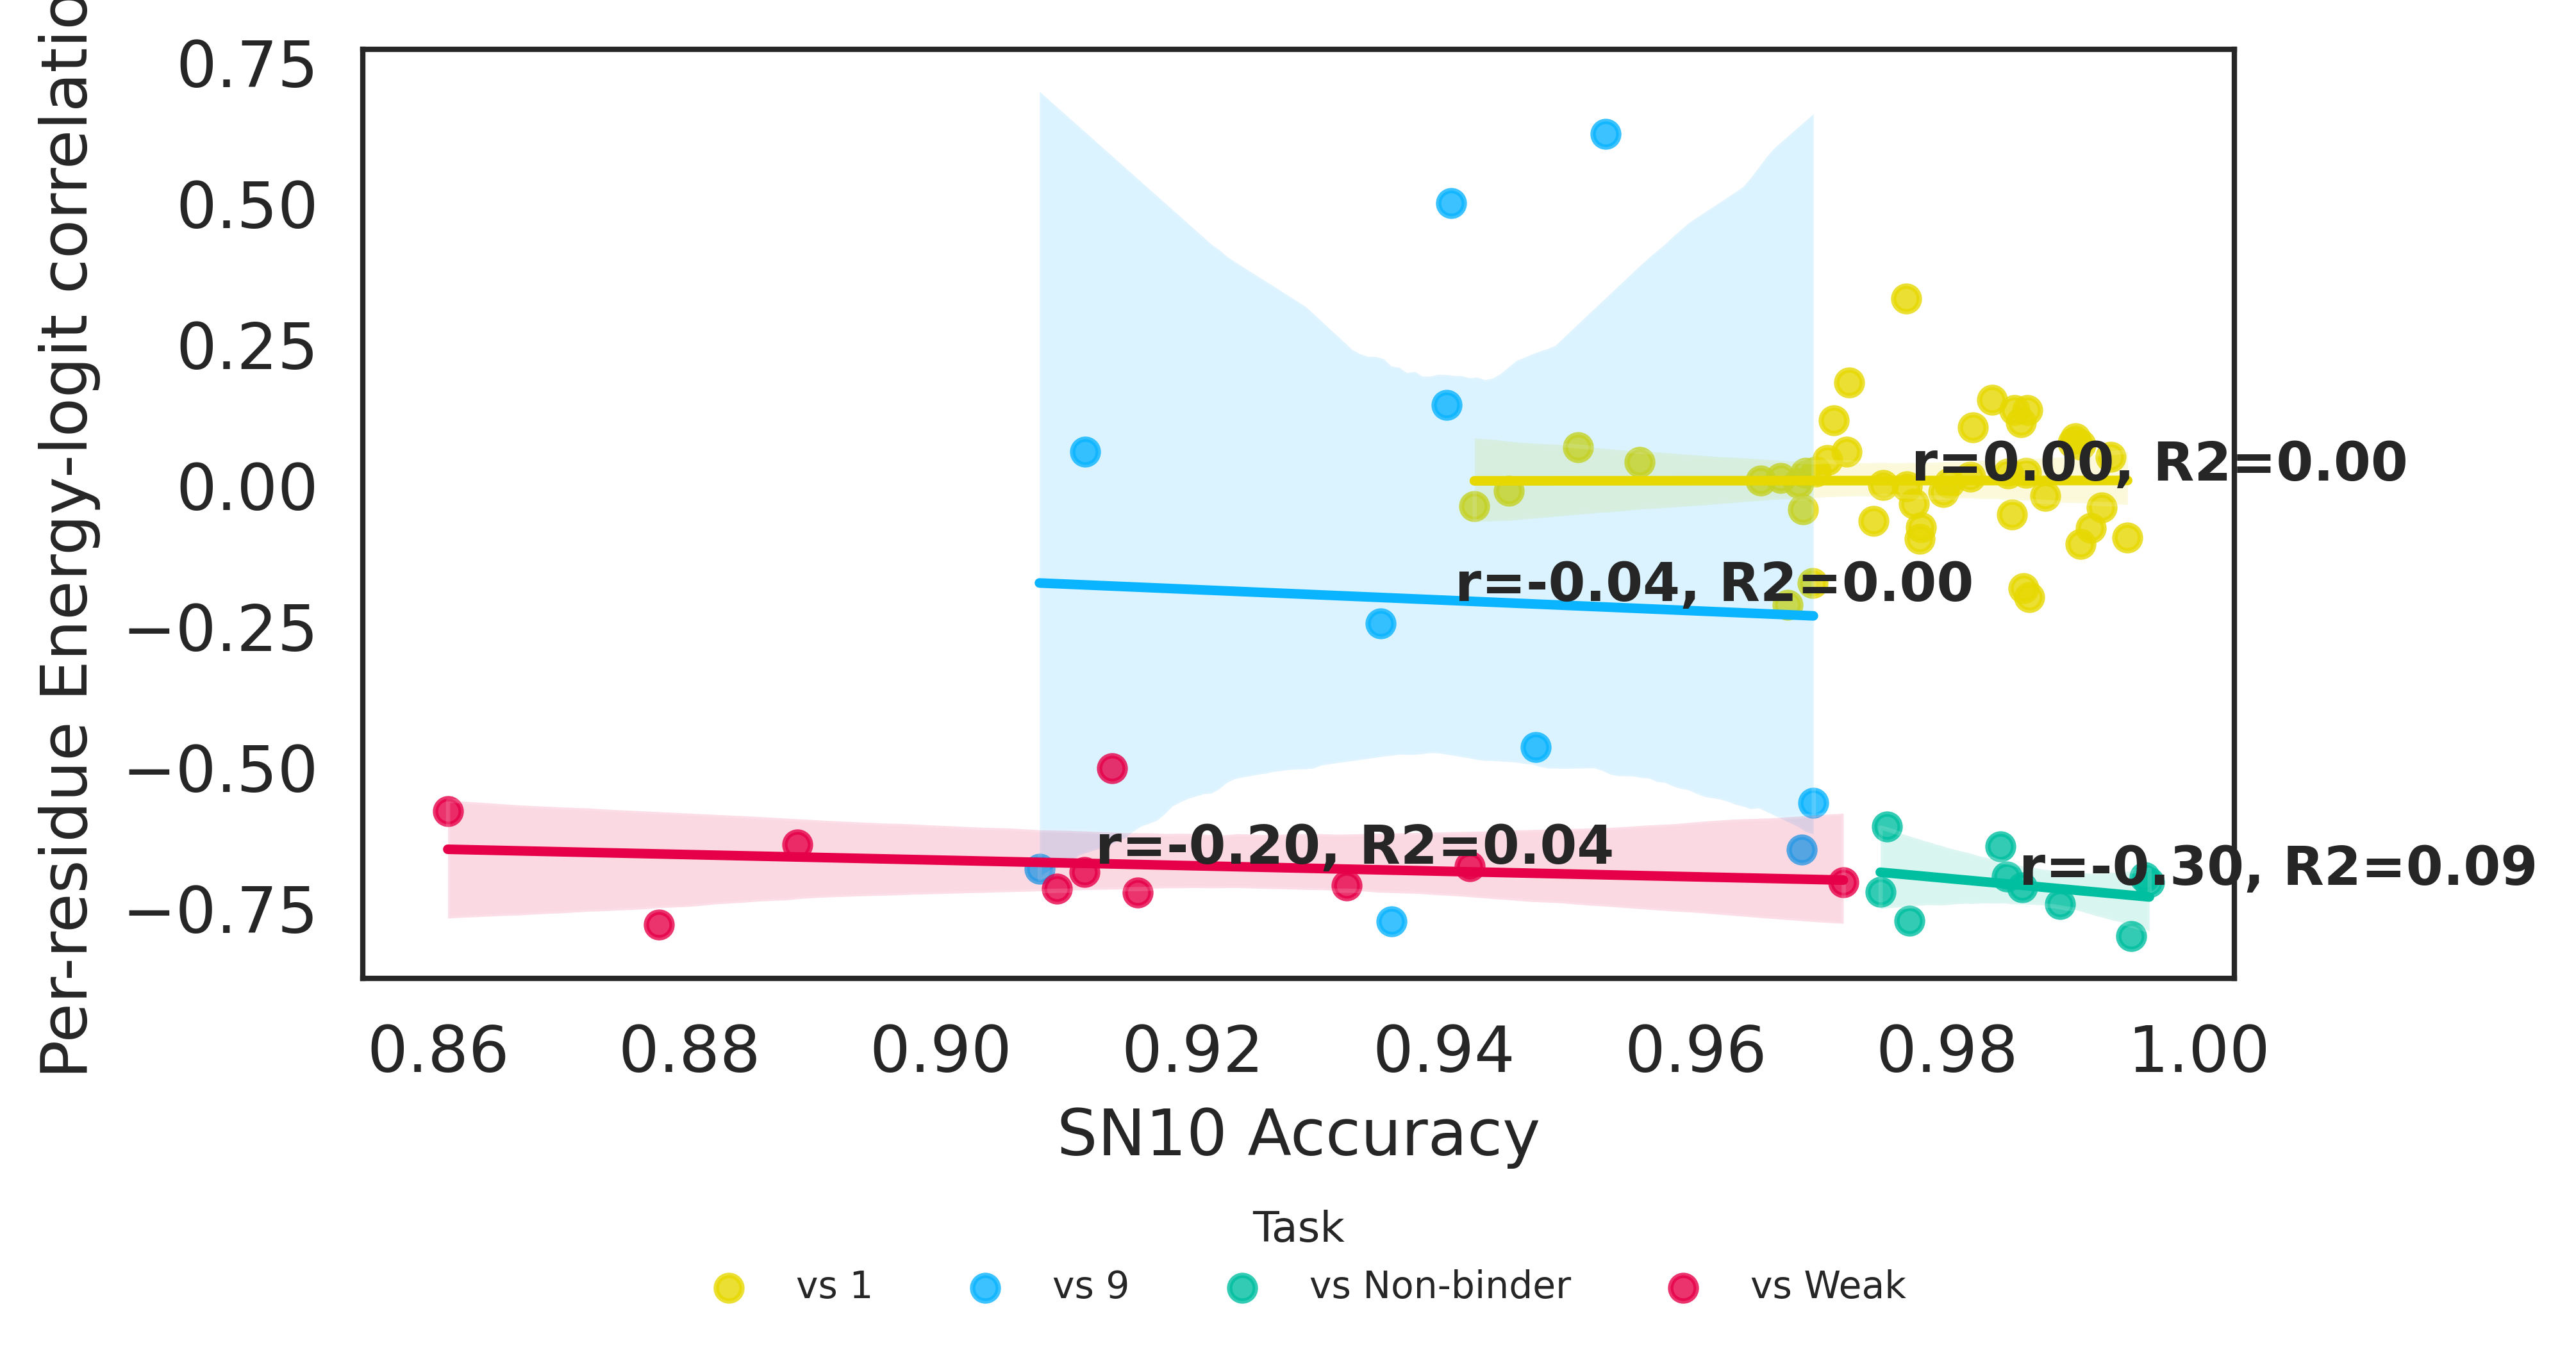

In [35]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Map to tasks clean
df_contributions_merged["task_type_clean"] = df_contributions_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# Line plot in seaborn with R2 regression
for i, df_g in df_contributions_merged.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="acc_closed",
        y="mean_pos_total",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["mean_pos_total"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    y = df_g["mean_pos_total"].mean()
    x = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_ylabel("Per-residue Energy-logit correlation", fontsize=FONT_SIZE)
ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

# ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

# fig.savefig("figures/1B.svg")
fig.show()

Plotting individual energy contributions correlations

In [36]:
def plot_energy_contributions_per_task(task, slide_class = "positive", plot_perc = False, ax = None):
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)
    all_energies = []
    all_energies_perc = []
    all_attrs = []
    all_attrs_perc = []

    for i, row in slide_df.iterrows():
        if row["class"] != slide_class:
            continue
        energies = row["energies"]
        all_energies += energies
        all_energies_perc += (np.array(energies) / np.sum(energies)).tolist()

        attrs = row["attributions"]
        all_attrs += attrs.tolist()
        all_attrs_perc += (np.array(attrs) / np.sum(np.abs(attrs))).tolist()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if plot_perc:
        ax.plot(
            all_attrs_perc, 
            all_energies_perc, 
            'o', 
            alpha=0.1,
            color="#f1593a", # red
            )
    else:
        ax.plot(all_attrs, all_energies, 'o', alpha=0.1)

    # Compute correlation and add text

    r, p = pearsonr(all_energies_perc, all_attrs_perc)
    r2 = r ** 2
    ax.text(
        0.23,
        0.03,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )

In [37]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 vs 9)")

In [38]:
sns.scatterplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
)

/tmp/ipykernel_834887/3403770409.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='SN10 Accuracy', ylabel='Per-residue Energy-logit correlation'>

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 0, 'Attribution (signed fraction)')

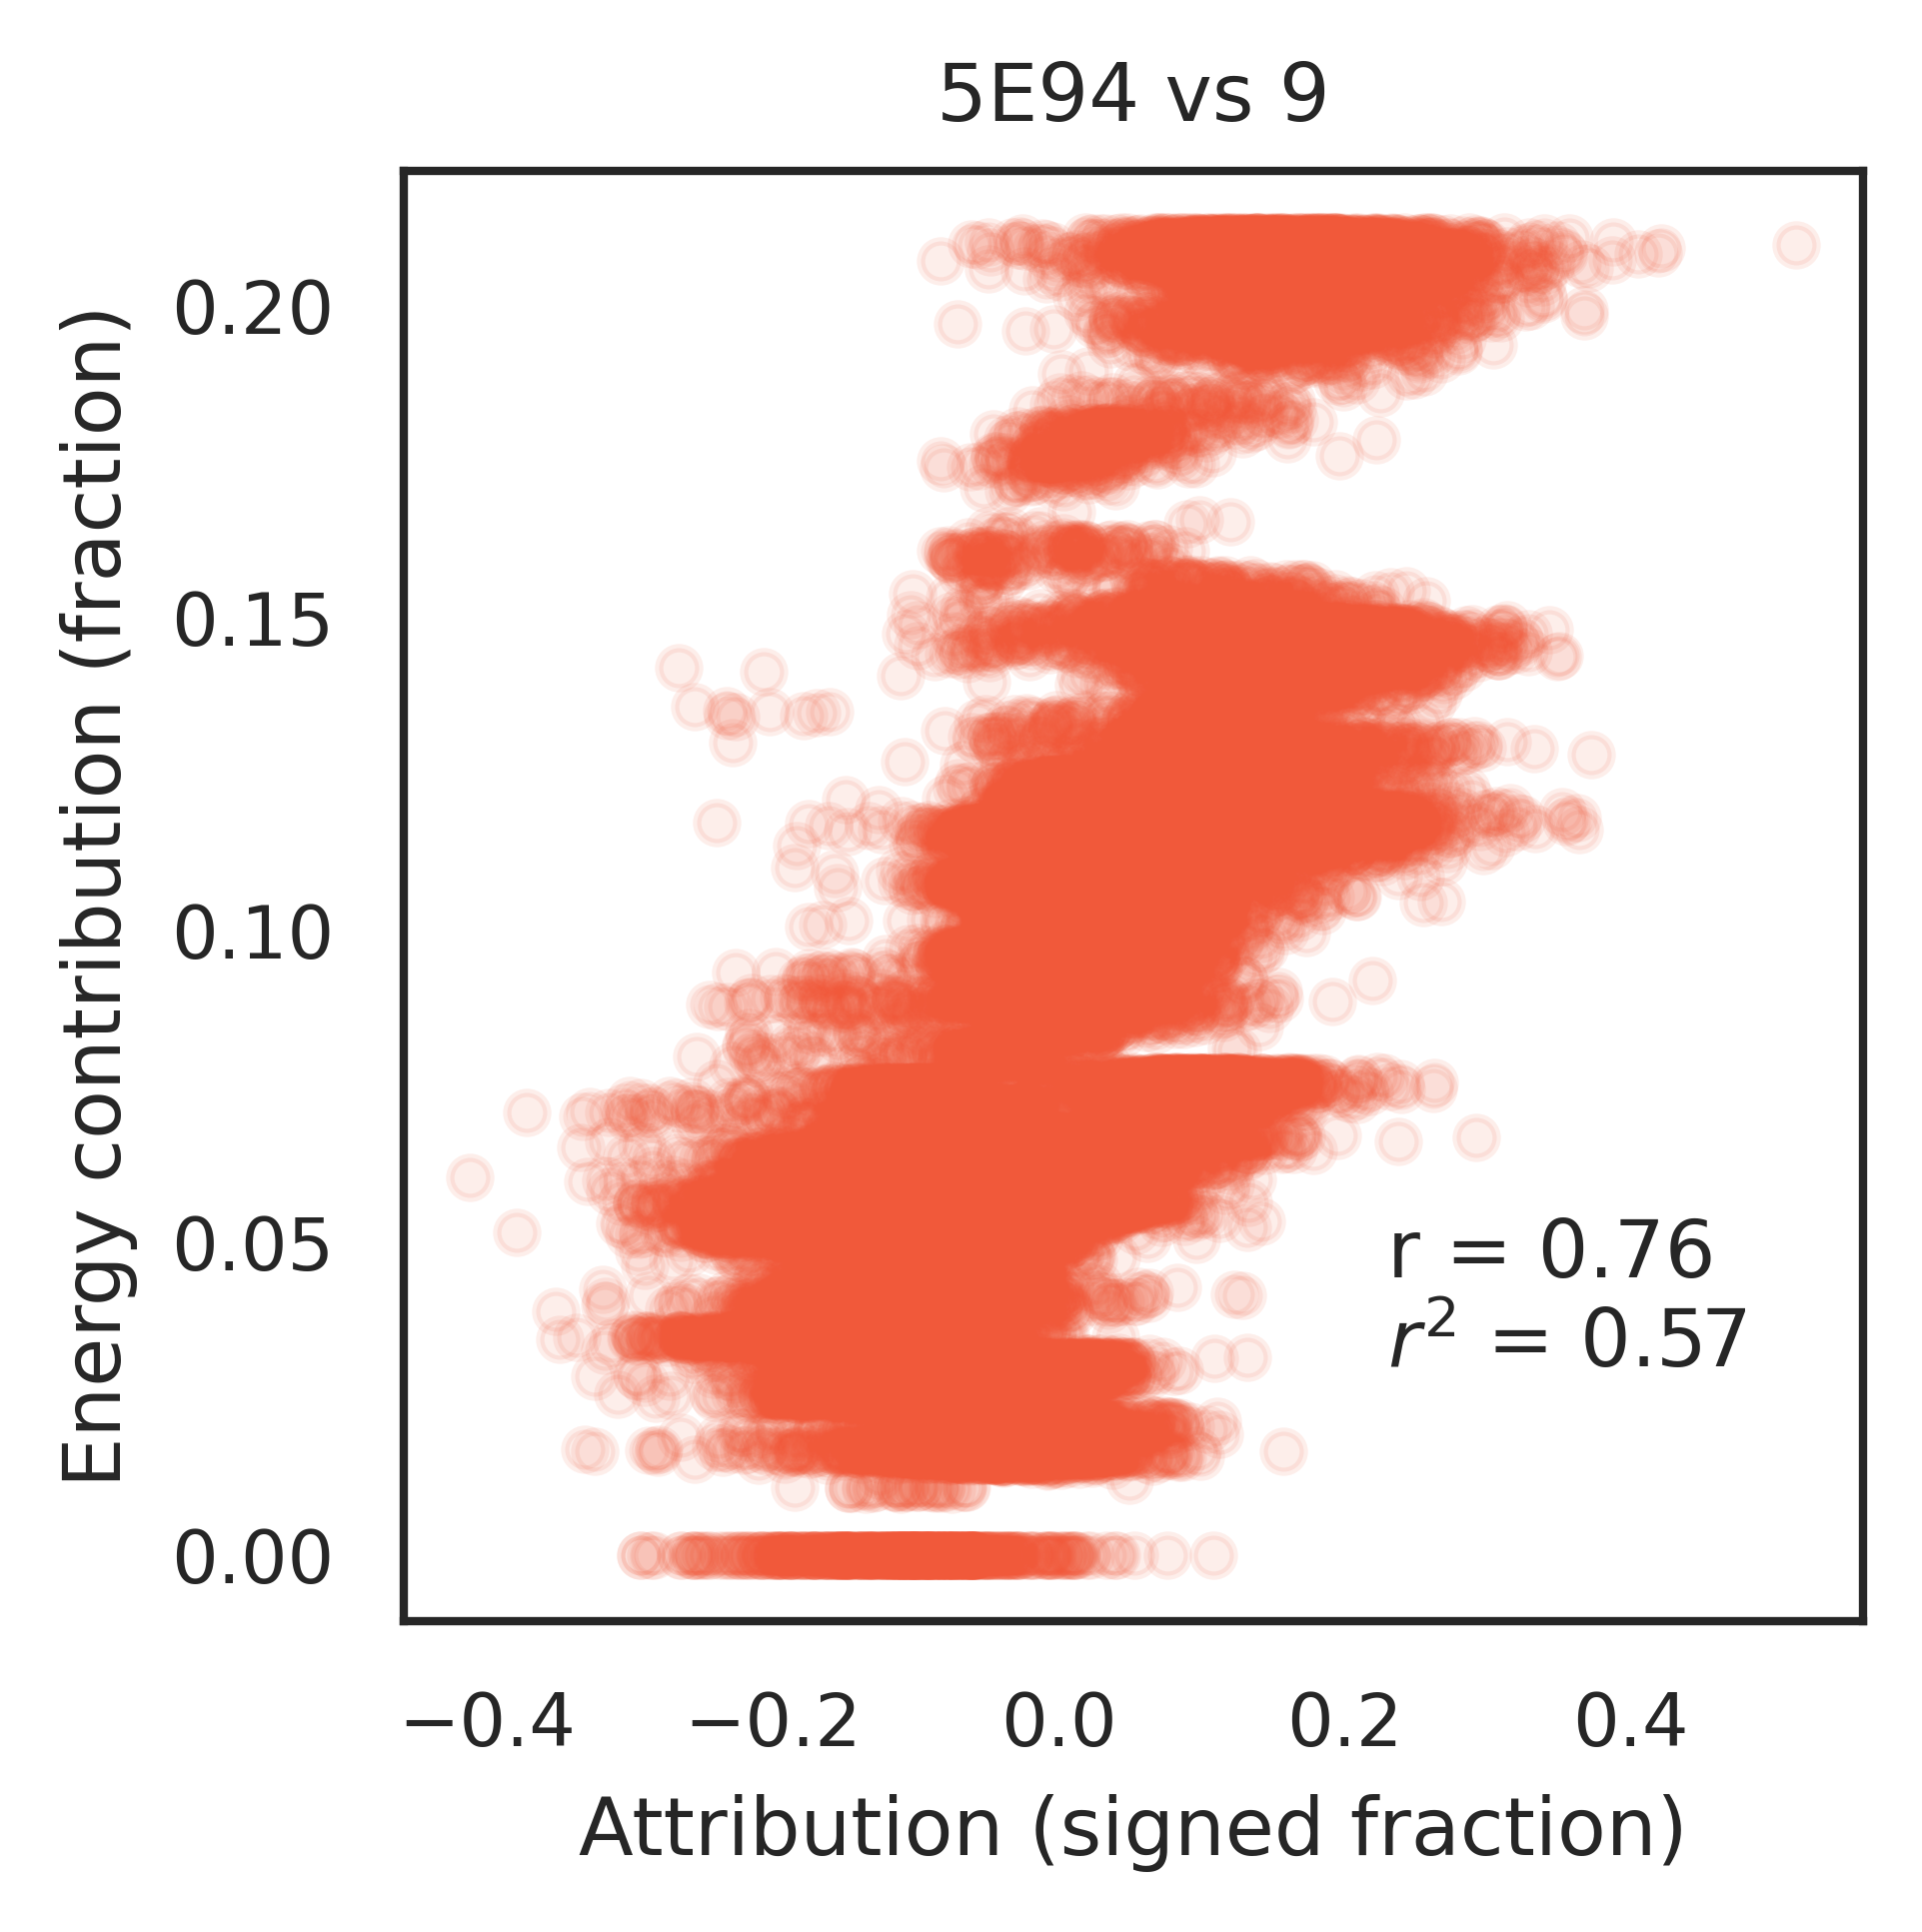

In [39]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=0,
)

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")

In [40]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN vs 9)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [41]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [42]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

Error analysis on AA Contributions

In [43]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


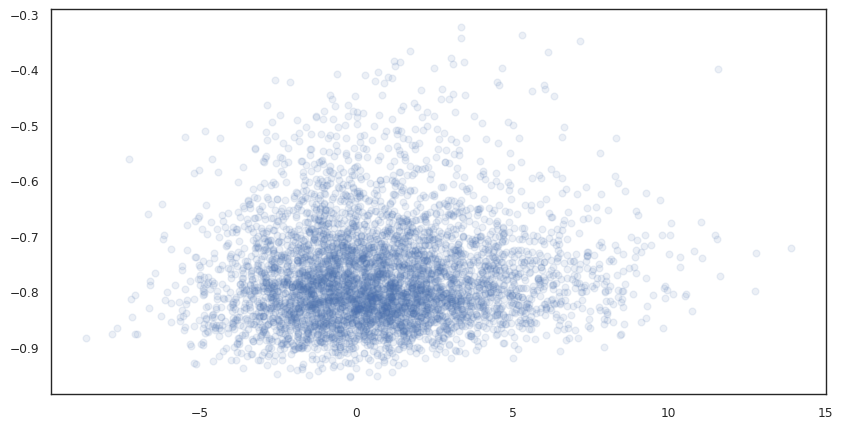

In [44]:
slide_df["attributions_sum"] = slide_df["attributions"].apply(lambda x: np.sum(x))

# Plot r_total vs attributions_sum
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(slide_df["attributions_sum"], slide_df["r_total"], 'o', alpha=0.1)

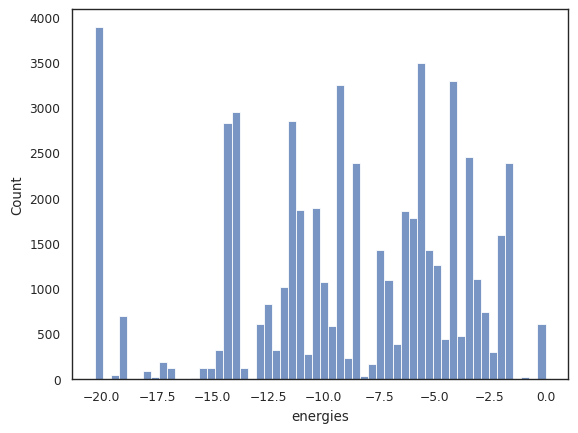

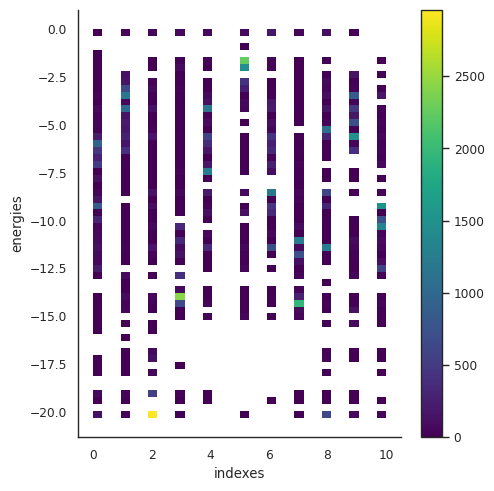

In [45]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

In [46]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="1NSN",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


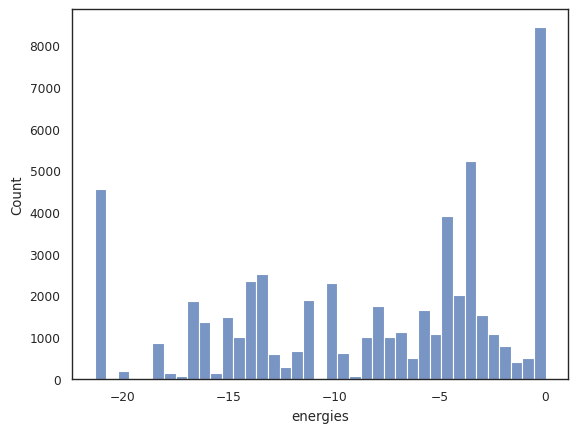

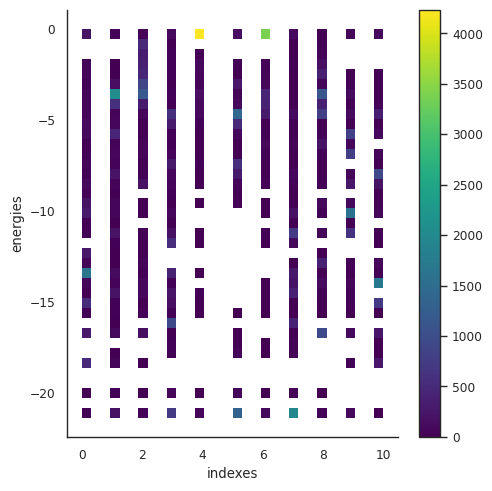

In [47]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scip

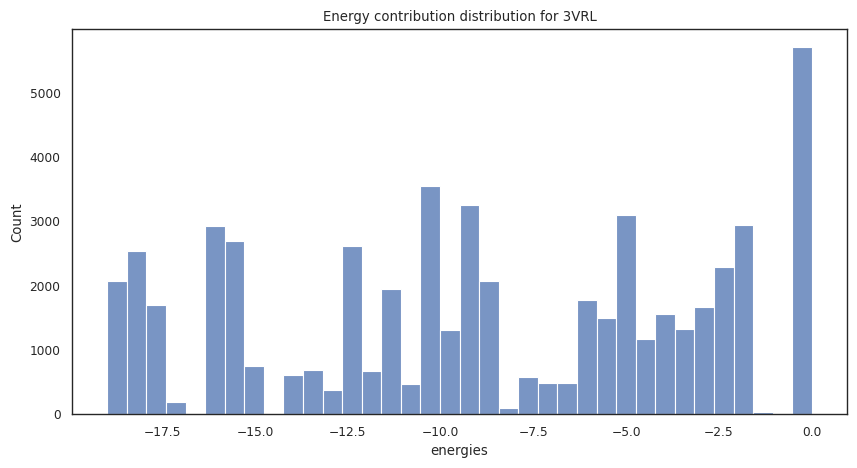

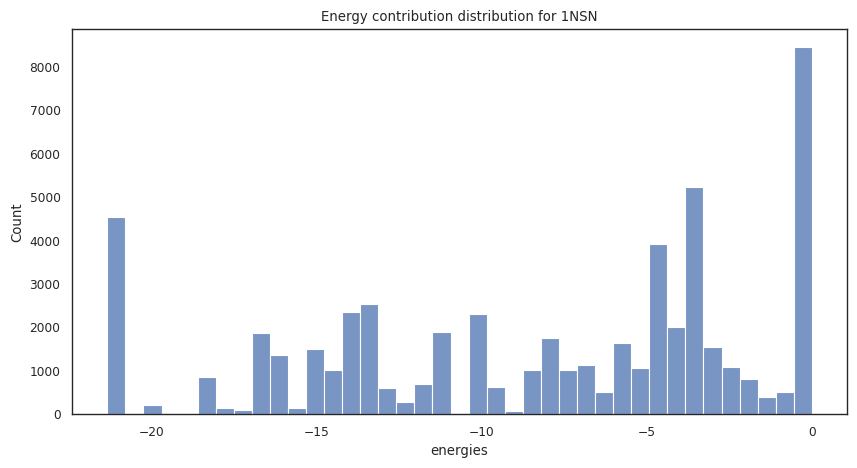

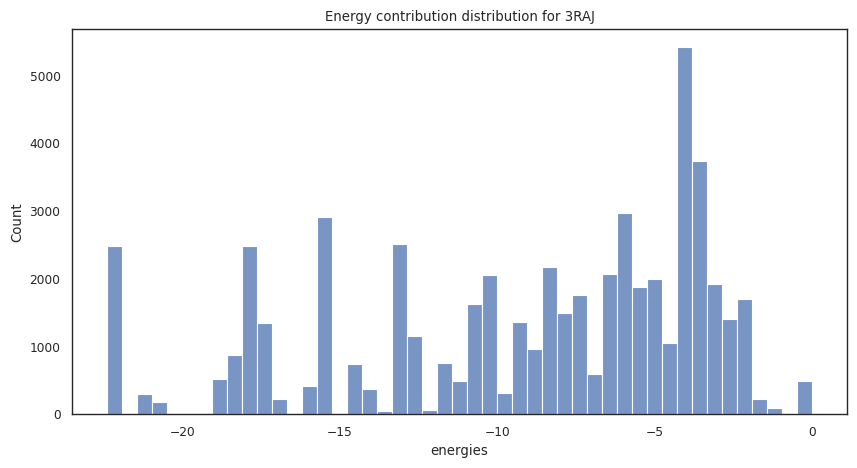

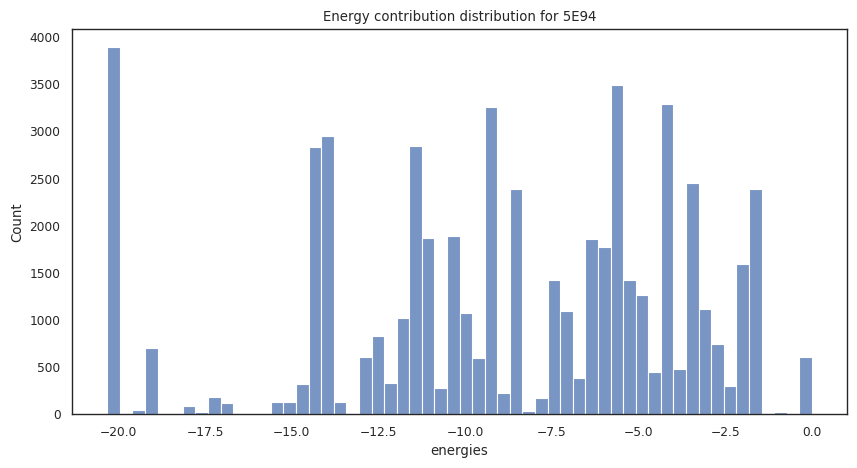

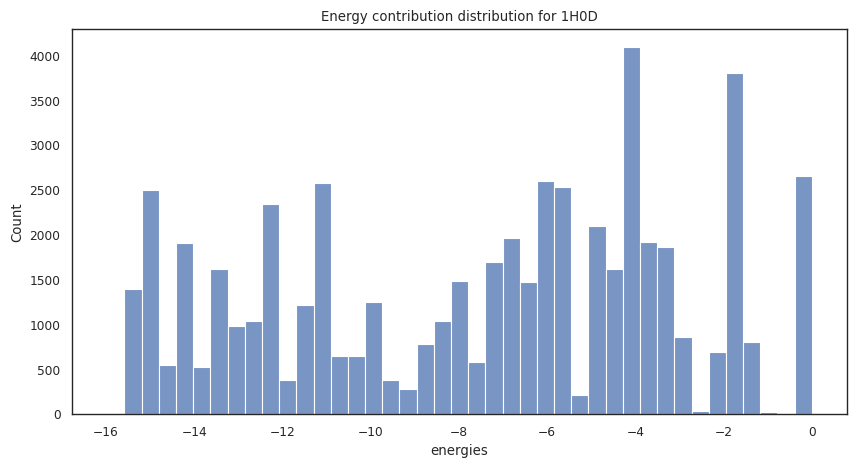

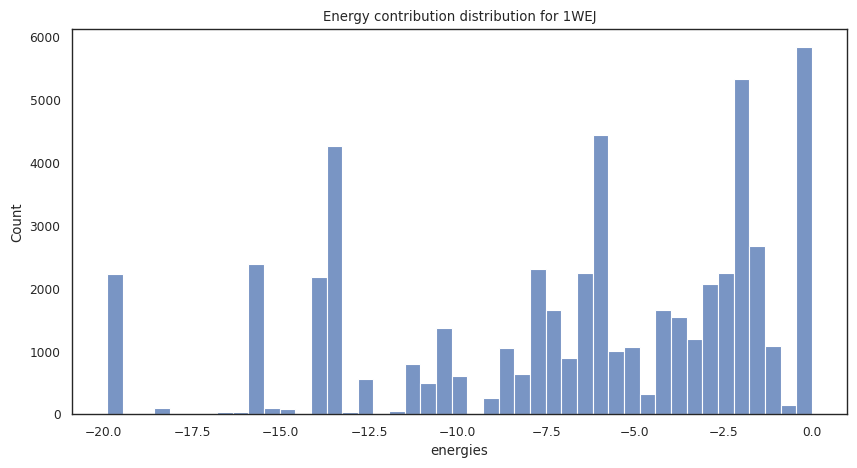

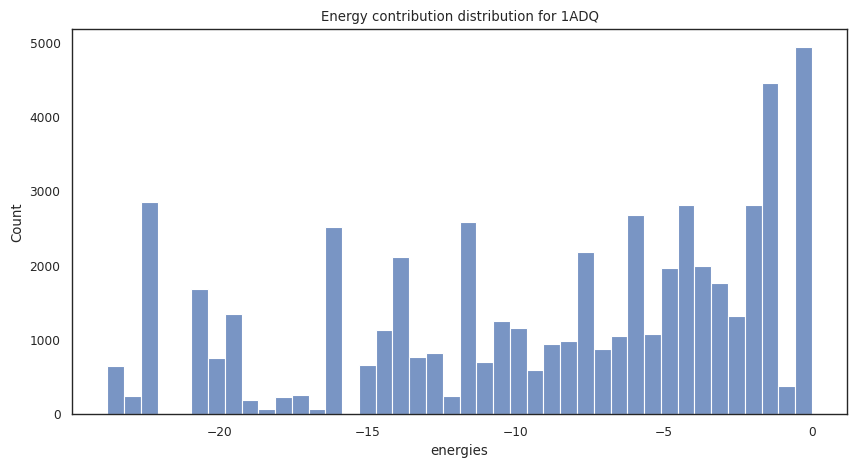

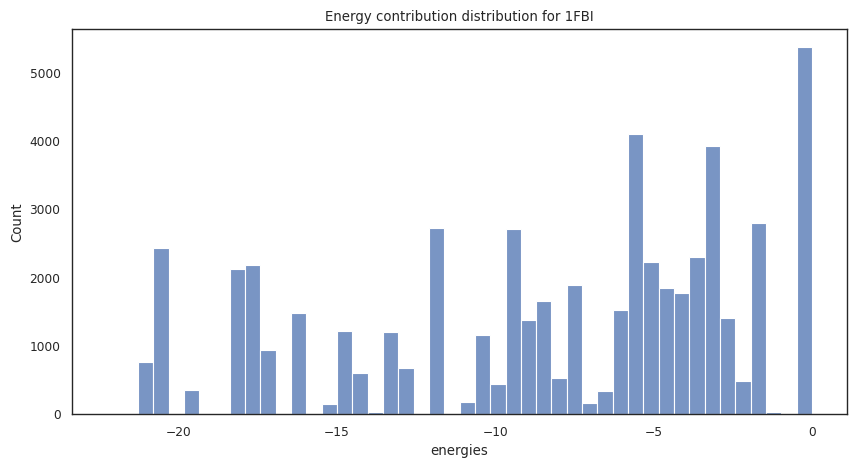

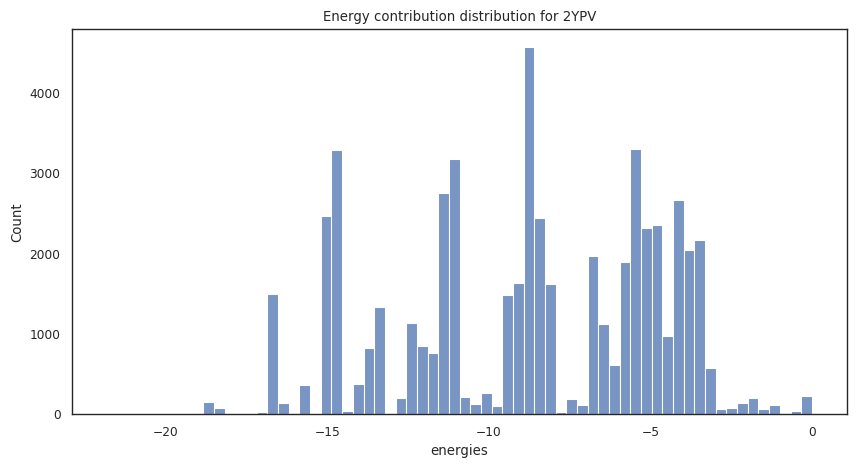

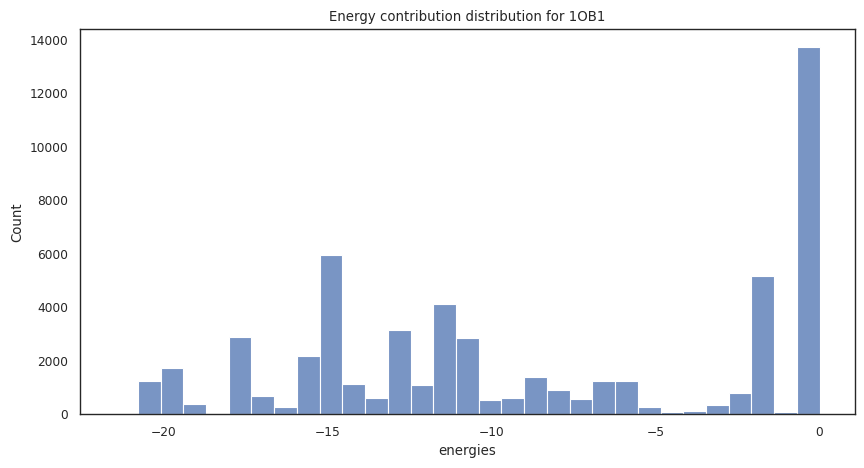

In [48]:
for ag in config.ANTIGENS:
    task = datasets.ClassificationTask(
        task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)
    
    energies = []
    indexes = []
    for i, row in slide_df.iterrows():
        energies_i = row["energies"]
        energies += energies_i
        indexes_i = list(range(0, 11))
        indexes += indexes_i

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        data=pd.DataFrame({"energies": energies, "indexes": indexes}),
        x="energies",
    )
    ax.set_title(f"Energy contribution distribution for {ag}")

Correlations between attributions and energy/logits.
- Better correlations for higher energies? Not necessarily.

In [49]:
list(task_generator())

[ONE_VS_ONE__3VRL__1NSN__0__42,
 ONE_VS_ONE__3VRL__1NSN__1__42,
 ONE_VS_ONE__3VRL__1NSN__2__42,
 ONE_VS_ONE__3VRL__1NSN__3__42,
 ONE_VS_ONE__3VRL__1NSN__0__0,
 ONE_VS_ONE__3VRL__1NSN__0__1,
 ONE_VS_ONE__3VRL__1NSN__0__2,
 ONE_VS_ONE__3VRL__1NSN__0__3,
 ONE_VS_ONE__3VRL__1NSN__0__4,
 ONE_VS_ONE__3VRL__3RAJ__0__42,
 ONE_VS_ONE__3VRL__3RAJ__1__42,
 ONE_VS_ONE__3VRL__3RAJ__2__42,
 ONE_VS_ONE__3VRL__3RAJ__3__42,
 ONE_VS_ONE__3VRL__3RAJ__0__0,
 ONE_VS_ONE__3VRL__3RAJ__0__1,
 ONE_VS_ONE__3VRL__3RAJ__0__2,
 ONE_VS_ONE__3VRL__3RAJ__0__3,
 ONE_VS_ONE__3VRL__3RAJ__0__4,
 ONE_VS_ONE__3VRL__5E94__0__42,
 ONE_VS_ONE__3VRL__5E94__1__42,
 ONE_VS_ONE__3VRL__5E94__2__42,
 ONE_VS_ONE__3VRL__5E94__3__42,
 ONE_VS_ONE__3VRL__5E94__0__0,
 ONE_VS_ONE__3VRL__5E94__0__1,
 ONE_VS_ONE__3VRL__5E94__0__2,
 ONE_VS_ONE__3VRL__5E94__0__3,
 ONE_VS_ONE__3VRL__5E94__0__4,
 ONE_VS_ONE__3VRL__1H0D__0__42,
 ONE_VS_ONE__3VRL__1H0D__1__42,
 ONE_VS_ONE__3VRL__1H0D__2__42,
 ONE_VS_ONE__3VRL__1H0D__3__42,
 ONE_VS_ONE__3VRL__1H0D

In [83]:
skip_errors_contrib = True
records = []
# for task in task_generator():
for task in task_generator():
    
    if task.task_type != datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        continue
    if "3VRL" in str(task) or "1NSN" in str(task):
        continue
    print(task)
    if skip_errors_contrib:
        try:
            stats, slide_df, energy_dict, attr_dict = load_energy_contributions_from_task_nonlinear_version(task, load_everything=True)
        except:
            continue
    else:
        stats, slide_df, energy_dict, attr_dict = load_energy_contributions_from_task_nonlinear_version(task, load_everything=True)

    break   
    records.append(stats)

# df_attrib = pd.DataFrame.from_records(records)
# df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

HIGH_VS_LOOSER__3RAJ__auto__0__42


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [84]:
slide_df

slide     class  \
0     CVIYNYFFDYW  positive   
1     WLLRTPYFDVW  positive   
2     ARLNYYFWYFD  positive   
3     RYLKLGLFDYW  positive   
4     CLLYSNYVGFA  positive   
...           ...       ...   
9993  LHFITTVVYFD  negative   
9994  CARSALRWLPF  negative   
9995  PLIYYGYAWFA  negative   
9996  CMPLFYYYGYY  negative   
9997  EFYYDFPFDYW  negative   

                                               energies  \
0     [-11.24, -5.99, -21.08, -3.52, -4.95, -4.17, -...   
1     [-11.11, -7.79, -22.39, -2.16, -5.65, -3.19, -...   
2     [-8.38, -3.97, -22.39, -2.08, -8.27, -4.17, -1...   
3     [-6.55, -5.98, -22.39, -1.35, -10.74, -3.01, -...   
4     [-11.24, -7.79, -22.39, -3.52, -4.97, -2.76, -...   
...                                                 ...   
9993  [-22.21, -4.31, -7.28, -14.75, 0.0, -7.25, -2....   
9994  [-17.2, -4.14, -4.03, -5.15, -7.44, -17.65, -3...   
9995  [-7.32, -7.79, -21.08, -3.52, -8.27, -3.01, -1...   
9996  [-9.78, -14.35, -4.25, -9.11, -15.45, -4.17, -...   
9997  [-3.56, -17.59, -10.14, -8.01, -1.21, 0.0, 0.0...   

                                           attributions         r         p  \
0     [0.8752020597457886, 0.10184021294116974, 2.69... -0.779432  0.004680   
1     [1.813378930091858, 2.3064677715301514, 5.4493... -0.818801  0.002053   
2     [-3.0678787231445312, -2.4180376529693604, 6.1... -0.847904  0.000976   
3     [-2.0039987564086914, 0.0828678235411644, 2.18... -0.762828  0.006321   
4     [1.801018476486206, 3.242760181427002, 5.43388... -0.798749  0.003193   
...                                                 ...       ...       ...   
9993  [1.1352155208587646, 0.38958945870399475, 1.32... -0.526297  0.096293   
9994  [1.4235681295394897, -2.533548355102539, -3.92... -0.830888  0.001533   
9995  [-4.14756965637207, 4.022040843963623, 3.90472... -0.678438  0.021738   
9996  [0.7165862321853638, 0.6112235188484192, -3.47... -0.564931  0.070164   
9997  [-4.145843505859375, 5.076630115509033, -0.144... -0.476689  0.138224   

        r_fold    p_fold   r_total   p_total  
0          NaN       NaN -0.779432  0.004680  
1          NaN       NaN -0.818801  0.002053  
2          NaN       NaN -0.847904  0.000976  
3          NaN       NaN -0.762828  0.006321  
4          NaN       NaN -0.798749  0.003193  
...        ...       ...       ...       ...  
9993 -0.330021  0.321606 -0.623555  0.040370  
9994       NaN       NaN -0.830888  0.001533  
9995       NaN       NaN -0.678438  0.021738  
9996  0.035898  0.916548 -0.580137  0.061346  
9997  0.242073  0.473277 -0.442008  0.173457  

[9998 rows x 10 columns]

In [85]:
attr_df = pd.DataFrame.from_records(attr_dict).transpose()
attr_df = pd.merge(attr_df, slide_df, on="slide")

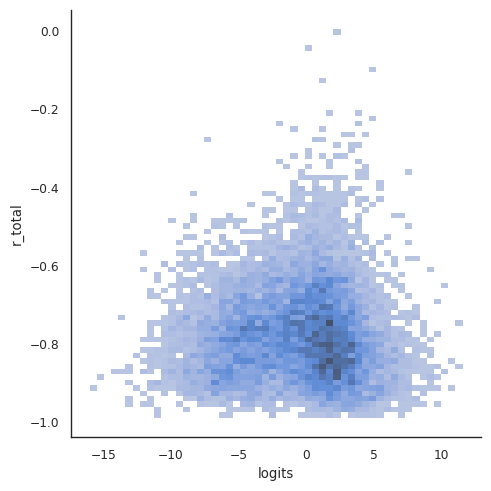

In [86]:
sns.displot(data=attr_df, x="logits", y="r_total", kind="hist")

In [82]:
# Correlation compute
r, p = pearsonr(attr_df["logits"], attr_df["r_total"])
r, p

(-0.20522237661818993, 1.549784412164382e-95)